In [1]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
from scipy.interpolate import interp1d
import scipy as sc
import matplotlib.cm as cm
from salishsea_tools import (nc_tools, gsw_calls, geo_tools, viz_tools)
import seabird
import cmocean as cmo
import gsw

from seabird.cnv import fCNV
import pandas as pd
import seaborn as sns
import matplotlib.gridspec as gridspec
import scipy.io
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size


from dateutil        import parser
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
%matplotlib inline
sns.set_context('paper')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
plt.style.use('seaborn')


In [2]:
NEP = nc.Dataset('/data/ssahu/NEP36_Extracted_Months/NEP36_2013_T_S_Spice_larger_offshore_rho_correct.nc')


sal = NEP.variables['vosaline']
temp = NEP.variables['votemper']
spic = NEP.variables['spiciness']
rho = NEP.variables['density']

zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]

mask = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/mesh_mask.nc')

tmask = mask.variables['tmask'][0,:32,180:350, 480:650]
umask = mask.variables['umask'][0,:32,180:350, 480:650]
vmask = mask.variables['vmask'][0,:32,180:350, 480:650]
mbathy = mask.variables['mbathy'][0,180:350, 480:650]


y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))




file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

lon = file_model.variables['nav_lon'][1:,1:]
lat = file_model.variables['nav_lat'][1:,1:]



lon_gsw = np.mean(lon)
lat_gsw = np.mean(lat)

In [3]:
path_of_file = '/data/ssahu/Falkor_2013/mvp/'

survey_file_A = path_of_file + 'surveyA.mat'
survey_file_B = path_of_file + 'surveyB.mat'
survey_file_D = path_of_file + 'surveyD.mat'
survey_file_E = path_of_file + 'surveyE.mat'
survey_file_G = path_of_file + 'surveyG.mat'

survey_file = [survey_file_A, survey_file_B, survey_file_D, survey_file_E, survey_file_G]

In [4]:
def MVP_survey_T_S_output_for_plot(file, SA_loc_cs_A, SA_loc_cs_B, SA_loc_cs_D, SA_loc_cs_E, SA_loc_cs_G,\
                                  CT_loc_cs_A, CT_loc_cs_B, CT_loc_cs_D, CT_loc_cs_E, CT_loc_cs_G):


    mat = scipy.io.loadmat(file)

    depths_survey = mat['depths'][:,0]
    lat_survey = mat['latitude'][:,0]
    lon_survey = mat['longitude'][:,0] - 100
    # den_survey = mat['density'][:]
    pden_survey = mat['pden'][:]
    temp_survey = mat['temp'][:]
    sal_survey = mat['salinity'][:]
    mtime = mat['mtime'][:,0]





    file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

    lon = file_model.variables['nav_lon'][1:,1:]
    lat = file_model.variables['nav_lat'][1:,1:]



    lon_gsw = np.mean(lon)
    lat_gsw = np.mean(lat)


    pressure_survey = np.empty_like(temp_survey)
    SA_survey = np.empty_like(temp_survey)
    CT_survey = np.empty_like(temp_survey)
    spic_survey = np.empty_like(temp_survey)
    rho_survey = np.empty_like(temp_survey)

    for j in np.arange(depths_survey.shape[0]):

        for i in np.arange(lat_survey.shape[0]):

            pressure_survey[j,i] = gsw.p_from_z(-depths_survey[j],lat_survey[i])

            SA_survey[j,i] = gsw.SA_from_SP(sal_survey[j,i], pressure_survey[j,i], lon_survey[i], lat_survey[i])

            CT_survey[j,i] = gsw.CT_from_pt(sal_survey[j,i], temp_survey[j,i])

            spic_survey[j,i] = gsw.spiciness0(SA_survey[j,i], CT_survey[j,i])

            rho_survey[j,i] = gsw.density.rho(SA_survey[j,i], CT_survey[j,i], 0)


    y = np.empty_like(lat_survey)
    x = np.empty_like(y)


    for i in np.arange(lat_survey.shape[0]):
        y[i], x[i] = geo_tools.find_closest_model_point(
                   lon_survey[i],lat_survey[i],lon,lat,tols={
            'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})


    SA_loc_cs = []
    CT_loc_cs = []

    for i in np.arange(sal_survey.shape[1]):
        SA_loc_cs = np.append(arr=SA_loc_cs, values= sal_survey[:,i][np.isfinite(sal_survey[:,i])])
        CT_loc_cs = np.append(arr=CT_loc_cs, values= temp_survey[:,i][~np.isnan(temp_survey[:,i])])

    if file[28:35] == 'surveyA':    
        SA_loc_cs_A = SA_loc_cs
        CT_loc_cs_A = CT_loc_cs

    if file[28:35] == 'surveyB':    
        SA_loc_cs_B = SA_loc_cs
        CT_loc_cs_B = CT_loc_cs

    if file[28:35] == 'surveyD':    
        SA_loc_cs_D = SA_loc_cs
        CT_loc_cs_D = CT_loc_cs

    if file[28:35] == 'surveyE':    
        SA_loc_cs_E = SA_loc_cs
        CT_loc_cs_E = CT_loc_cs    

    if file[28:35] == 'surveyG':    
        SA_loc_cs_G = SA_loc_cs
        CT_loc_cs_G = CT_loc_cs  
        
    return SA_loc_cs_A, CT_loc_cs_A, SA_loc_cs_B, CT_loc_cs_B, \
SA_loc_cs_D, CT_loc_cs_D, SA_loc_cs_E, CT_loc_cs_E, \
SA_loc_cs_G, CT_loc_cs_G

In [5]:
SA_loc_cs_A = []; SA_loc_cs_B = []; SA_loc_cs_D = []; SA_loc_cs_E = []; SA_loc_cs_G = []
CT_loc_cs_A = []; CT_loc_cs_B = []; CT_loc_cs_D = []; CT_loc_cs_E = []; CT_loc_cs_G = []


for file in survey_file:

    SA_loc_cs_A, CT_loc_cs_A, SA_loc_cs_B, CT_loc_cs_B, \
    SA_loc_cs_D, CT_loc_cs_D, SA_loc_cs_E, CT_loc_cs_E, \
    SA_loc_cs_G, CT_loc_cs_G = MVP_survey_T_S_output_for_plot(file, SA_loc_cs_A=SA_loc_cs_A, SA_loc_cs_B=SA_loc_cs_B,\
                                                             SA_loc_cs_D=SA_loc_cs_D, SA_loc_cs_E=SA_loc_cs_E,\
                                                             SA_loc_cs_G=SA_loc_cs_G, CT_loc_cs_A = CT_loc_cs_A, CT_loc_cs_B = CT_loc_cs_B,\
                                                             CT_loc_cs_D = CT_loc_cs_D, CT_loc_cs_E =CT_loc_cs_E, \
                                                             CT_loc_cs_G = CT_loc_cs_G)

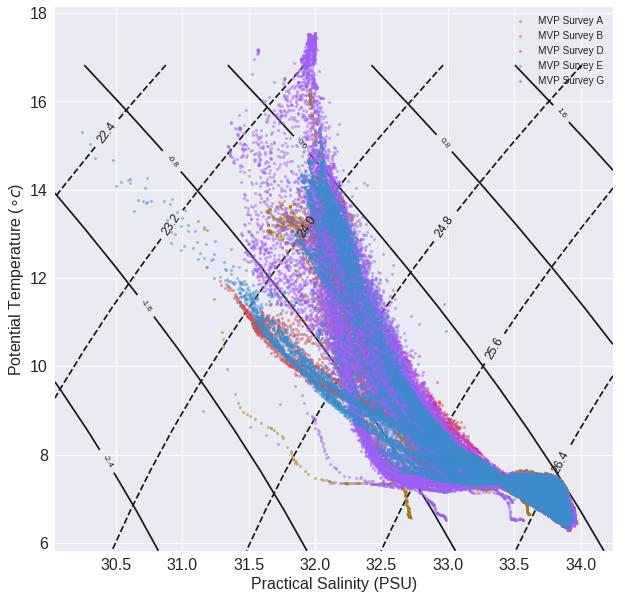

In [85]:
colors = cmo.cm.phase(np.linspace(0, 1, 203))

SA_loc_cs_D1 = SA_loc_cs_D[SA_loc_cs_D>30]
CT_loc_cs_D1 = CT_loc_cs_D[SA_loc_cs_D>30]

# Figure out boudaries (mins and maxs)
smin = SA_loc_cs_G.min() - (0.01 * SA_loc_cs_G.min())
smax = SA_loc_cs_G.max() + (0.01 * SA_loc_cs_G.max())
tmin = CT_loc_cs_G.min() - (0.1 * CT_loc_cs_G.max())
tmax = CT_loc_cs_G.max() + (0.1 * CT_loc_cs_G.max())
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, lon_gsw, lat_gsw)

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = plt.contour(si,ti,dens_1, linestyles='dashed', colors='k')
CS1 = plt.contour(si,ti,spic_1, linestyles='solid', colors='k')
plt.clabel(CS, fontsize=12, inline=1, fmt='%0.1f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.1f') # Label every second level


ax.plot(SA_loc_cs_A ,CT_loc_cs_A,'o', color= colors[0,:], alpha = 0.5, markersize=3, label='MVP Survey A')

ax.plot(SA_loc_cs_B ,CT_loc_cs_B, 'o',color= colors[30,:],alpha = 0.5,  markersize=3, label='MVP Survey B')

ax.plot(SA_loc_cs_D1 ,CT_loc_cs_D1, 'o',color= colors[60,:],alpha = 0.5,  markersize=3, label='MVP Survey D')

ax.plot(SA_loc_cs_E ,CT_loc_cs_E, 'o',color= colors[90,:], alpha = 0.5, markersize=3, label='MVP Survey E')

ax.plot(SA_loc_cs_G ,CT_loc_cs_G, 'o',color= colors[120,:], alpha = 0.5, markersize=3, label='MVP Survey G')

# ax.plot(SA_loc_f, CT_loc_f, 'o' ,markersize=9, label = 'Eddy west front')
# ax.set_ylim(5,18)
# ax.set_xlim(30,34)
 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
# ax.set_xlim(31.5,)


legend = ax.legend(loc='upper right', fancybox=True, framealpha=0.25)

In [6]:
def model_data_MVP_survey_T_S_output_for_plot(file, model_survey_sal_A, model_survey_sal_B, model_survey_sal_D, model_survey_sal_E, model_survey_sal_G,\
                                  model_survey_temp_A, model_survey_temp_B, model_survey_temp_D, model_survey_temp_E, model_survey_temp_G):


    mat = scipy.io.loadmat(file)

    depths_survey = mat['depths'][:,0]
    lat_survey = mat['latitude'][:,0]
    lon_survey = mat['longitude'][:,0] - 100





    file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

    lon = file_model.variables['nav_lon'][1:,1:]
    lat = file_model.variables['nav_lat'][1:,1:]



    lon_gsw = np.mean(lon)
    lat_gsw = np.mean(lat)


    y = np.empty_like(lat_survey)
    x = np.empty_like(y)


    for i in np.arange(lat_survey.shape[0]):
        y[i], x[i] = geo_tools.find_closest_model_point(
                   lon_survey[i],lat_survey[i],lon,lat,tols={
            'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

        
    model_survey_sal  = np.empty((sal.shape[1],y.shape[0]))
    model_survey_temp = np.empty_like(model_survey_sal)
    model_survey_rho  = np.empty_like(model_survey_sal)
    model_survey_spic = np.empty_like(model_survey_sal)

    if file[28:35] == 'surveyA':
        t =116
    if file[28:35] == 'surveyB':
        t =116
    if file[28:35] == 'surveyD':
        t =118
    if file[28:35] == 'surveyE':
        t =119
    if file[28:35] == 'surveyG':
        t =120


    for i in np.arange(y.shape[0]):
        model_survey_sal[:,i]   = sal[t,:,y[i],x[i]]
        model_survey_temp[:,i]  = temp[t,:,y[i],x[i]]
        model_survey_spic[:,i]  = spic[t,:,y[i],x[i]]
        model_survey_rho[:,i]   = rho[t,:,y[i],x[i]]

    model_survey_temp[model_survey_temp == 0] = np.nan
    model_survey_sal[model_survey_sal == 0] = np.nan
    model_survey_spic[model_survey_temp == 0] = np.nan
    model_survey_rho[model_survey_temp == 0]  = np.nan
    
    SA_loc_cs = []
    CT_loc_cs = []
    

    for i in np.arange(model_survey_sal.shape[1]):
        SA_loc_cs = np.append(arr=SA_loc_cs, values= model_survey_sal[:,i][np.isfinite(model_survey_sal[:,i])])
        CT_loc_cs = np.append(arr=CT_loc_cs, values= model_survey_temp[:,i][~np.isnan(model_survey_temp[:,i])])


    if file[28:35] == 'surveyA':    
        model_survey_temp_A = CT_loc_cs
        model_survey_sal_A = SA_loc_cs

    if file[28:35] == 'surveyB':    
        model_survey_sal_B = SA_loc_cs
        model_survey_temp_B = CT_loc_cs

    if file[28:35] == 'surveyD':    
        model_survey_sal_D = SA_loc_cs
        model_survey_temp_D = CT_loc_cs

    if file[28:35] == 'surveyE':    
        model_survey_sal_E = SA_loc_cs
        model_survey_temp_E = CT_loc_cs   

    if file[28:35] == 'surveyG':    
        model_survey_sal_G = SA_loc_cs
        model_survey_temp_G = CT_loc_cs 
        
    return model_survey_sal_A, model_survey_temp_A, model_survey_sal_B, model_survey_temp_B, \
model_survey_sal_D, model_survey_temp_D, model_survey_sal_E, model_survey_temp_E, \
model_survey_sal_G, model_survey_temp_G

In [7]:
def model_spice_density_MVP_survey_T_S_output_for_plot(file, model_survey_spic_A, model_survey_spic_B, model_survey_spic_D, model_survey_spic_E, model_survey_spic_G,\
                                                       model_survey_rho_A, model_survey_rho_B, model_survey_rho_D, model_survey_rho_E, model_survey_rho_G):


    mat = scipy.io.loadmat(file)

    depths_survey = mat['depths'][:,0]
    lat_survey = mat['latitude'][:,0]
    lon_survey = mat['longitude'][:,0] - 100





    file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

    lon = file_model.variables['nav_lon'][1:,1:]
    lat = file_model.variables['nav_lat'][1:,1:]



    lon_gsw = np.mean(lon)
    lat_gsw = np.mean(lat)


    y = np.empty_like(lat_survey)
    x = np.empty_like(y)


    for i in np.arange(lat_survey.shape[0]):
        y[i], x[i] = geo_tools.find_closest_model_point(
                   lon_survey[i],lat_survey[i],lon,lat,tols={
            'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

        
    model_survey_sal  = np.empty((sal.shape[1],y.shape[0]))
    model_survey_temp = np.empty_like(model_survey_sal)
    model_survey_rho  = np.empty_like(model_survey_sal)
    model_survey_spic = np.empty_like(model_survey_sal)

    if file[28:35] == 'surveyA':
        t =116
    if file[28:35] == 'surveyB':
        t =116
    if file[28:35] == 'surveyD':
        t =118
    if file[28:35] == 'surveyE':
        t =119
    if file[28:35] == 'surveyG':
        t =120


    for i in np.arange(y.shape[0]):
        model_survey_sal[:,i]   = sal[t,:,y[i],x[i]]
        model_survey_temp[:,i]  = temp[t,:,y[i],x[i]]
        model_survey_spic[:,i]  = spic[t,:,y[i],x[i]]
        model_survey_rho[:,i]   = rho[t,:,y[i],x[i]]

    model_survey_temp[model_survey_temp == 0] = np.nan
    model_survey_sal[model_survey_sal == 0] = np.nan
    model_survey_spic[model_survey_temp == 0] = np.nan
    model_survey_rho[model_survey_temp == 0]  = np.nan
    
    SPIC_loc_cs = []
    RHO_loc_cs = []
    

    for i in np.arange(model_survey_sal.shape[1]):
        SPIC_loc_cs = np.append(arr=SPIC_loc_cs, values= model_survey_spic[:,i][np.isfinite(model_survey_spic[:,i])])
        RHO_loc_cs = np.append(arr=RHO_loc_cs, values= model_survey_rho[:,i][~np.isnan(model_survey_rho[:,i])])


    if file[28:35] == 'surveyA':    
        model_survey_spic_A = SPIC_loc_cs
        model_survey_rho_A = RHO_loc_cs

    if file[28:35] == 'surveyB':    
        model_survey_spic_B = SPIC_loc_cs
        model_survey_rho_B = RHO_loc_cs

    if file[28:35] == 'surveyD':    
        model_survey_spic_D = SPIC_loc_cs
        model_survey_rho_D = RHO_loc_cs

    if file[28:35] == 'surveyE':    
        model_survey_spic_E = SPIC_loc_cs
        model_survey_rho_E = RHO_loc_cs   

    if file[28:35] == 'surveyG':    
        model_survey_spic_G = SPIC_loc_cs
        model_survey_rho_G = RHO_loc_cs
        
    return model_survey_spic_A, model_survey_rho_A, model_survey_spic_B, model_survey_rho_B, \
model_survey_spic_D, model_survey_rho_D, model_survey_spic_E, model_survey_rho_E, \
model_survey_spic_G, model_survey_rho_G

In [8]:
model_survey_sal_A = []; model_survey_sal_B = []; model_survey_sal_D = []; model_survey_sal_E = []; model_survey_sal_G = []
model_survey_temp_A = []; model_survey_temp_B = []; model_survey_temp_D = []; model_survey_temp_E = []; model_survey_temp_G = []


for file in survey_file:

    model_survey_sal_A, model_survey_temp_A, model_survey_sal_B, model_survey_temp_B, \
    model_survey_sal_D, model_survey_temp_D,\
    model_survey_sal_E, model_survey_temp_E, \
    model_survey_sal_G, model_survey_temp_G = model_data_MVP_survey_T_S_output_for_plot(file=file, model_survey_sal_A=model_survey_sal_A,model_survey_sal_B=model_survey_sal_B, \
                                                                                        model_survey_sal_D=model_survey_sal_D, model_survey_sal_E = model_survey_sal_E , \
                                                                                        model_survey_sal_G = model_survey_sal_G, \
                                                                                        model_survey_temp_A = model_survey_temp_A, \
                                                                                        model_survey_temp_B = model_survey_temp_B, \
                                                                                        model_survey_temp_D = model_survey_temp_D, \
                                                                                        model_survey_temp_E = model_survey_temp_E, \
                                                                                        model_survey_temp_G =model_survey_temp_G)

In [9]:
model_survey_spic_A = []; model_survey_spic_B = []; model_survey_spic_D = []; model_survey_spic_E = []; model_survey_spic_G = []
model_survey_rho_A = []; model_survey_rho_B = []; model_survey_rho_D = []; model_survey_rho_E = []; model_survey_rho_G = []


for file in survey_file:

    model_survey_spic_A, model_survey_rho_A, model_survey_spic_B, model_survey_rho_B, \
    model_survey_spic_D, model_survey_rho_D,\
    model_survey_spic_E, model_survey_rho_E, \
    model_survey_spic_G, model_survey_rho_G = model_spice_density_MVP_survey_T_S_output_for_plot(file=file, model_survey_spic_A=model_survey_spic_A,model_survey_spic_B=model_survey_spic_B, \
                                                                                                 model_survey_spic_D=model_survey_spic_D, model_survey_spic_E = model_survey_spic_E ,\
                                                                                                 model_survey_spic_G = model_survey_spic_G,\
                                                                                                 model_survey_rho_A = model_survey_rho_A,\
                                                                                                 model_survey_rho_B = model_survey_rho_B,\
                                                                                                 model_survey_rho_D = model_survey_rho_D,\
                                                                                                 model_survey_rho_E = model_survey_rho_E,\
                                                                                                 model_survey_rho_G =model_survey_rho_G)

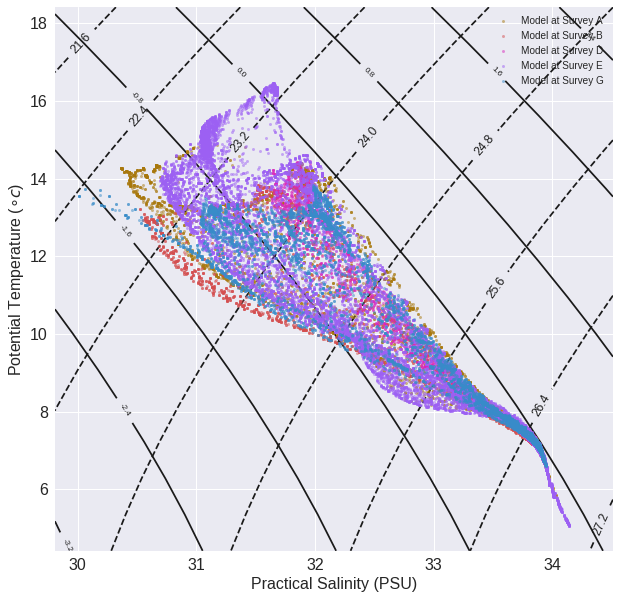

In [86]:
colors = cmo.cm.phase(np.linspace(0, 1, 200))

model_survey_sal_G1 = model_survey_sal_G[model_survey_sal_G>30]
model_survey_temp_G1 = model_survey_temp_G[model_survey_sal_G>30]

# Figure out boudaries (mins and maxs)
smin = np.nanmin(model_survey_sal_G1)  - (0.01 * np.nanmin(model_survey_sal_G1))
smax = np.nanmax(model_survey_sal_E)  + (0.01 * np.nanmax(model_survey_sal_E))
tmin = np.nanmin(model_survey_temp_E) - (0.1 * np.nanmax(model_survey_temp_E))
tmax = np.nanmax(model_survey_temp_E) + (0.1 * np.nanmax(model_survey_temp_E))
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, lon_gsw, lat_gsw)

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = plt.contour(si,ti,dens_1, linestyles='dashed', colors='k')
CS1 = plt.contour(si,ti,spic_1, linestyles='solid', colors='k')
plt.clabel(CS, fontsize=12, inline=1, fmt='%0.1f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.1f') # Label every second level


ax.plot(model_survey_sal_A ,model_survey_temp_A,'o', color= colors[0,:], alpha = 0.5, markersize=3, label='Model at Survey A')

ax.plot(model_survey_sal_B ,model_survey_temp_B, 'o',color= colors[30,:],alpha = 0.5,  markersize=3, label='Model at Survey B')

ax.plot(model_survey_sal_D ,model_survey_temp_D, 'o',color= colors[60,:],alpha = 0.5,  markersize=3, label='Model at Survey D')

ax.plot(model_survey_sal_E ,model_survey_temp_E, 'o',color= colors[90,:], alpha = 0.5, markersize=3, label='Model at Survey E')

ax.plot(model_survey_sal_G1 ,model_survey_temp_G1, 'o',color= colors[120,:], alpha = 0.5, markersize=3, label='Model at Survey G')

# ax.plot(SA_loc_f, CT_loc_f, 'o' ,markersize=9, label = 'Eddy west front')
# ax.set_ylim(5,18)
# ax.set_xlim(30,34)
 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
# ax.set_xlim(31.5,)


legend = ax.legend(loc='upper right', fancybox=True, framealpha=0.25)

In [47]:
smin

-1.7667890676532204e+308

In [36]:
mat = scipy.io.loadmat(survey_mat_file_A)

In [79]:
depths_survey = mat['depths'][:,0]
lat_survey = mat['latitude'][:,0]
lon_survey = mat['longitude'][:,0] - 100
# den_survey = mat['density'][:]
pden_survey = mat['pden'][:]
temp_survey = mat['temp'][:]
sal_survey = mat['salinity'][:]
mtime = mat['mtime'][:,0]

In [6]:
sal_survey.shape

(251, 203)

In [41]:
survey_mat_file_B = '/data/ssahu/Falkor_2013/mvp/surveyB.mat'
mat = scipy.io.loadmat(survey_mat_file_B)

In [60]:
survey_mat_file_D = '/data/ssahu/Falkor_2013/mvp/surveyD.mat'
mat = scipy.io.loadmat(survey_mat_file_D)

In [66]:
survey_mat_file_E = '/data/ssahu/Falkor_2013/mvp/surveyE.mat'
mat = scipy.io.loadmat(survey_mat_file_E)

In [78]:
survey_mat_file_G = '/data/ssahu/Falkor_2013/mvp/surveyG.mat'
mat = scipy.io.loadmat(survey_mat_file_G)

In [13]:
sal_survey.shape

(251, 168)

In [14]:
depths_survey.shape

(251,)

In [16]:
depths_survey[-1]

250.0

In [7]:
file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

lon = file_model.variables['nav_lon'][1:,1:]
lat = file_model.variables['nav_lat'][1:,1:]



lon_gsw = np.mean(lon)
lat_gsw = np.mean(lat)


pressure_survey = np.empty_like(temp_survey)
SA_survey = np.empty_like(temp_survey)
CT_survey = np.empty_like(temp_survey)
spic_survey = np.empty_like(temp_survey)
rho_survey = np.empty_like(temp_survey)

for j in np.arange(depths_survey.shape[0]):

    for i in np.arange(lat_survey.shape[0]):

        pressure_survey[j,i] = gsw.p_from_z(-depths_survey[j],lat_survey[i])

        SA_survey[j,i] = gsw.SA_from_SP(sal_survey[j,i], pressure_survey[j,i], lon_survey[i], lat_survey[i])

        CT_survey[j,i] = gsw.CT_from_pt(sal_survey[j,i], temp_survey[j,i])

        spic_survey[j,i] = gsw.spiciness0(SA_survey[j,i], CT_survey[j,i])

        rho_survey[j,i] = gsw.density.rho(SA_survey[j,i], CT_survey[j,i], 0)


y = np.empty_like(lat_survey)
x = np.empty_like(y)


for i in np.arange(lat_survey.shape[0]):
    y[i], x[i] = geo_tools.find_closest_model_point(
               lon_survey[i],lat_survey[i],lon,lat,tols={
        'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})


In [53]:
temp_survey.shape

(251, 203)

In [81]:
SA_loc_cs = []
CT_loc_cs = []

for i in np.arange(sal_survey.shape[1]):
    SA_loc_cs = np.append(arr=SA_loc_cs, values= sal_survey[:,i][np.isfinite(sal_survey[:,i])])
    CT_loc_cs = np.append(arr=CT_loc_cs, values= temp_survey[:,i][~np.isnan(temp_survey[:,i])])

In [40]:
SA_loc_cs_A = SA_loc_cs
CT_loc_cs_A = CT_loc_cs



In [45]:
SA_loc_cs_B = SA_loc_cs
CT_loc_cs_B = CT_loc_cs

In [64]:
SA_loc_cs_D = SA_loc_cs
CT_loc_cs_D = CT_loc_cs

In [70]:
SA_loc_cs_E = SA_loc_cs
CT_loc_cs_E = CT_loc_cs

In [82]:
SA_loc_cs_G = SA_loc_cs
CT_loc_cs_G = CT_loc_cs

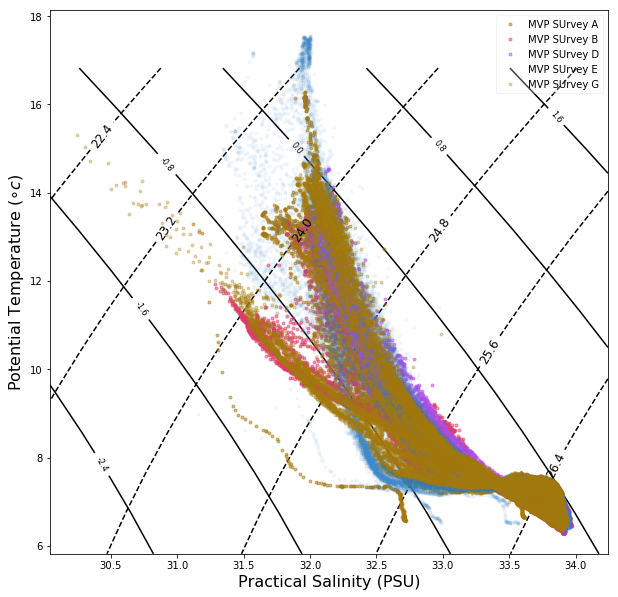

In [84]:
colors = cmo.cm.phase(np.linspace(0, 1, y.shape[0]))

SA_loc_cs_D1 = SA_loc_cs_D[SA_loc_cs_D>30]
CT_loc_cs_D1 = CT_loc_cs_D[SA_loc_cs_D>30]

# Figure out boudaries (mins and maxs)
smin = SA_loc_cs.min() - (0.01 * SA_loc_cs.min())
smax = SA_loc_cs.max() + (0.01 * SA_loc_cs.max())
tmin = CT_loc_cs.min() - (0.1 * CT_loc_cs.max())
tmax = CT_loc_cs.max() + (0.1 * CT_loc_cs.max())
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, lon_gsw, lat_gsw)

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = plt.contour(si,ti,dens_1, linestyles='dashed', colors='k')
CS1 = plt.contour(si,ti,spic_1, linestyles='solid', colors='k')
plt.clabel(CS, fontsize=12, inline=1, fmt='%0.1f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.1f') # Label every second level


ax.plot(SA_loc_cs_A ,CT_loc_cs_A,'o', color= colors[0,:], alpha = 0.5, markersize=3, label='MVP SUrvey A')

ax.plot(SA_loc_cs_B ,CT_loc_cs_B, 'o',color= colors[40,:],alpha = 0.5,  markersize=3, label='MVP SUrvey B')

ax.plot(SA_loc_cs_D1 ,CT_loc_cs_D1, 'o',color= colors[80,:],alpha = 0.5,  markersize=3, label='MVP SUrvey D')

ax.plot(SA_loc_cs_E ,CT_loc_cs_E, 'o',color= colors[120,:], alpha = 0.05, markersize=3, label='MVP SUrvey E')

ax.plot(SA_loc_cs_G ,CT_loc_cs_G, 'o',color= colors[200,:], alpha = 0.3, markersize=3, label='MVP SUrvey G')

# ax.plot(SA_loc_f, CT_loc_f, 'o' ,markersize=9, label = 'Eddy west front')
# ax.set_ylim(5,18)
# ax.set_xlim(30,34)
 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
# ax.set_xlim(31.5,)


legend = ax.legend(loc='upper right', fancybox=True, framealpha=0.25)

In [59]:
SA_loc_cs_D.shape

(15750,)

In [10]:
model_survey_sal  = np.empty((sal.shape[1],y.shape[0],y.shape[0]))
model_survey_temp = np.empty_like(model_survey_sal)
model_survey_rho  = np.empty_like(model_survey_sal)
model_survey_spic = np.empty_like(model_survey_sal)

t = 116


for i in np.arange(y.shape[0]):
    model_survey_sal[:,i,i]   = sal[t,:,y[i],x[i]]
    model_survey_temp[:,i,i]  = temp[t,:,y[i],x[i]]
    model_survey_spic[:,i,i]  = spic[t,:,y[i],x[i]]
    model_survey_rho[:,i,i]   = rho[t,:,y[i],x[i]]

model_survey_temp[model_survey_temp == 0] = np.nan
model_survey_sal[model_survey_sal == 0] = np.nan
model_survey_spic[model_survey_temp == 0] = np.nan

In [77]:
colors = matplotlib.cm.rainbow(np.linspace(0, 1, y.shape[0]))

In [79]:
colors.shape

(203, 4)

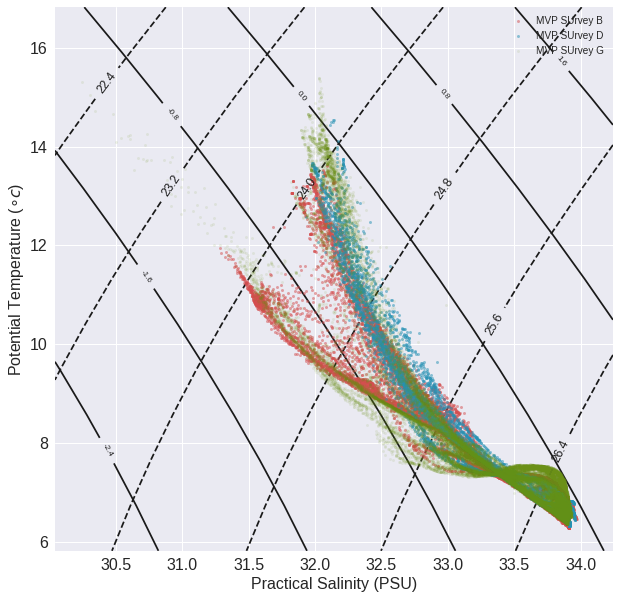

In [87]:
colors = cmo.cm.phase(np.linspace(0, 1, 203))

SA_loc_cs_D1 = SA_loc_cs_D[SA_loc_cs_D>30]
CT_loc_cs_D1 = CT_loc_cs_D[SA_loc_cs_D>30]

# Figure out boudaries (mins and maxs)
smin = SA_loc_cs_G.min() - (0.01 * SA_loc_cs_G.min())
smax = SA_loc_cs_G.max() + (0.01 * SA_loc_cs_G.max())
tmin = CT_loc_cs_G.min() - (0.1 * CT_loc_cs_G.max())
tmax = CT_loc_cs_G.max() + (0.1 * CT_loc_cs_G.max())
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, lon_gsw, lat_gsw)

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = plt.contour(si,ti,dens_1, linestyles='dashed', colors='k')
CS1 = plt.contour(si,ti,spic_1, linestyles='solid', colors='k')
plt.clabel(CS, fontsize=12, inline=1, fmt='%0.1f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.1f') # Label every second level


# ax.plot(SA_loc_cs_A ,CT_loc_cs_A,'o', color= colors[0,:], alpha = 0.5, markersize=3, label='MVP SUrvey A')

ax.plot(SA_loc_cs_B ,CT_loc_cs_B, 'o',color= colors[30,:],alpha = 0.5,  markersize=3, label='MVP SUrvey B')

ax.plot(SA_loc_cs_D1 ,CT_loc_cs_D1, 'o',color= colors[130,:],alpha = 0.5,  markersize=3, label='MVP SUrvey D')

# ax.plot(SA_loc_cs_E ,CT_loc_cs_E, 'o',color= colors[90,:], alpha = 0.5, markersize=3, label='MVP SUrvey E')

ax.plot(SA_loc_cs_G ,CT_loc_cs_G, 'o',color= colors[180,:], alpha = 0.1, markersize=3, label='MVP SUrvey G')

# ax.plot(SA_loc_f, CT_loc_f, 'o' ,markersize=9, label = 'Eddy west front')
# ax.set_ylim(5,18)
# ax.set_xlim(30,34)
 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
# ax.set_xlim(31.5,)


legend = ax.legend(loc='upper right', fancybox=True, framealpha=1)

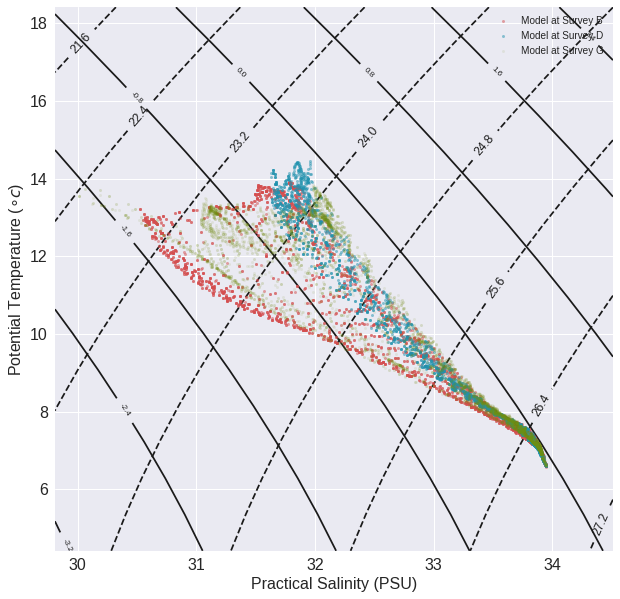

In [88]:
colors = cmo.cm.phase(np.linspace(0, 1, 200))

model_survey_sal_G1 = model_survey_sal_G[model_survey_sal_G>30]
model_survey_temp_G1 = model_survey_temp_G[model_survey_sal_G>30]

# Figure out boudaries (mins and maxs)
smin = np.nanmin(model_survey_sal_G1)  - (0.01 * np.nanmin(model_survey_sal_G1))
smax = np.nanmax(model_survey_sal_E)  + (0.01 * np.nanmax(model_survey_sal_E))
tmin = np.nanmin(model_survey_temp_E) - (0.1 * np.nanmax(model_survey_temp_E))
tmax = np.nanmax(model_survey_temp_E) + (0.1 * np.nanmax(model_survey_temp_E))
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, lon_gsw, lat_gsw)

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = plt.contour(si,ti,dens_1, linestyles='dashed', colors='k')
CS1 = plt.contour(si,ti,spic_1, linestyles='solid', colors='k')
plt.clabel(CS, fontsize=12, inline=1, fmt='%0.1f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.1f') # Label every second level


# ax.plot(model_survey_sal_A ,model_survey_temp_A,'o', color= colors[0,:], alpha = 0.5, markersize=3, label='Model at Survey A')

ax.plot(model_survey_sal_B ,model_survey_temp_B, 'o',color= colors[30,:],alpha = 0.5,  markersize=3, label='Model at Survey B')

ax.plot(model_survey_sal_D ,model_survey_temp_D, 'o',color= colors[130,:],alpha = 0.5,  markersize=3, label='Model at Survey D')

# ax.plot(model_survey_sal_E ,model_survey_temp_E, 'o',color= colors[90,:], alpha = 0.5, markersize=3, label='Model at Survey E')

ax.plot(model_survey_sal_G1 ,model_survey_temp_G1, 'o',color= colors[180,:], alpha = 0.1, markersize=3, label='Model at Survey G')

# ax.plot(SA_loc_f, CT_loc_f, 'o' ,markersize=9, label = 'Eddy west front')
# ax.set_ylim(5,18)
# ax.set_xlim(30,34)
 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
# ax.set_xlim(31.5,)


legend = ax.legend(loc='upper right', fancybox=True, framealpha=0.25)

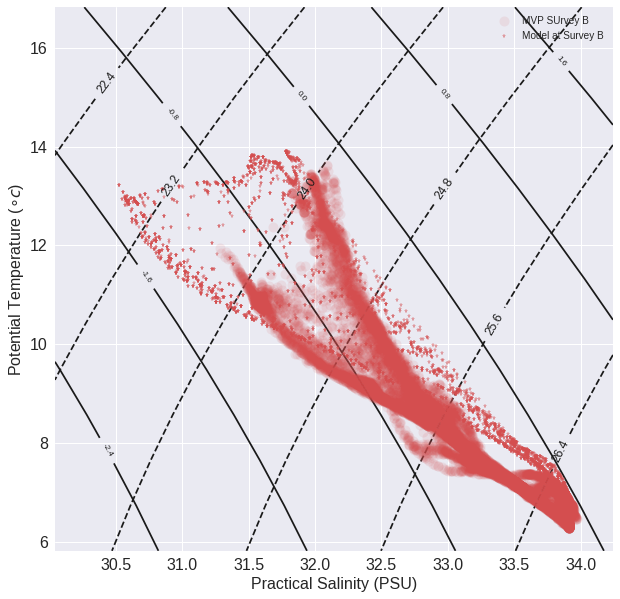

In [89]:
colors = cmo.cm.phase(np.linspace(0, 1, 203))

SA_loc_cs_D1 = SA_loc_cs_D[SA_loc_cs_D>30]
CT_loc_cs_D1 = CT_loc_cs_D[SA_loc_cs_D>30]

# Figure out boudaries (mins and maxs)
smin = SA_loc_cs_G.min() - (0.01 * SA_loc_cs_G.min())
smax = SA_loc_cs_G.max() + (0.01 * SA_loc_cs_G.max())
tmin = CT_loc_cs_G.min() - (0.1 * CT_loc_cs_G.max())
tmax = CT_loc_cs_G.max() + (0.1 * CT_loc_cs_G.max())
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, lon_gsw, lat_gsw)

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = plt.contour(si,ti,dens_1, linestyles='dashed', colors='k')
CS1 = plt.contour(si,ti,spic_1, linestyles='solid', colors='k')
plt.clabel(CS, fontsize=12, inline=1, fmt='%0.1f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.1f') # Label every second level


# ax.plot(SA_loc_cs_A ,CT_loc_cs_A,'o', color= colors[0,:], alpha = 0.5, markersize=3, label='MVP SUrvey A')

ax.plot(SA_loc_cs_B ,CT_loc_cs_B, 'o',color= colors[30,:],alpha = 0.1,  markersize=10, label='MVP SUrvey B')

# ax.plot(SA_loc_cs_D1 ,CT_loc_cs_D1, 'o',color= colors[130,:],alpha = 0.5,  markersize=5, label='MVP SUrvey D')

# ax.plot(SA_loc_cs_E ,CT_loc_cs_E, 'o',color= colors[90,:], alpha = 0.5, markersize=3, label='MVP SUrvey E')

# ax.plot(SA_loc_cs_G ,CT_loc_cs_G, 'o',color= colors[180,:], alpha = 0.1, markersize=5, label='MVP SUrvey G')



ax.plot(model_survey_sal_B ,model_survey_temp_B, '*',color= colors[30,:],alpha = 0.5,  markersize=5, label='Model at Survey B')

# ax.plot(model_survey_sal_D ,model_survey_temp_D, '*',color= colors[130,:],alpha = 0.5,  markersize=5, label='Model at Survey D')

# ax.plot(model_survey_sal_E ,model_survey_temp_E, 'o',color= colors[90,:], alpha = 0.5, markersize=3, label='Model at Survey E')

# ax.plot(model_survey_sal_G1 ,model_survey_temp_G1, '*',color= colors[180,:], alpha = 0.1, markersize=5, label='Model at Survey G')

# ax.plot(SA_loc_f, CT_loc_f, 'o' ,markersize=9, label = 'Eddy west front')
# ax.set_ylim(5,18)
# ax.set_xlim(30,34)
 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
# ax.set_xlim(31.5,)


legend = ax.legend(loc='upper right', fancybox=True, framealpha=1)

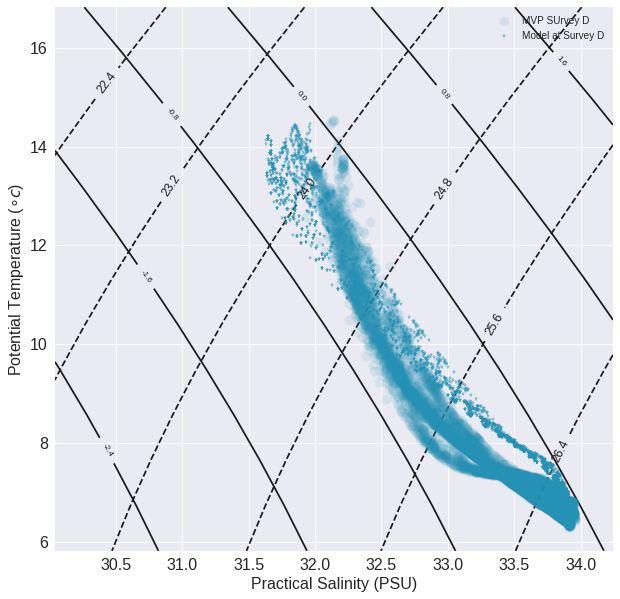

In [90]:
colors = cmo.cm.phase(np.linspace(0, 1, 203))

SA_loc_cs_D1 = SA_loc_cs_D[SA_loc_cs_D>30]
CT_loc_cs_D1 = CT_loc_cs_D[SA_loc_cs_D>30]

# Figure out boudaries (mins and maxs)
smin = SA_loc_cs_G.min() - (0.01 * SA_loc_cs_G.min())
smax = SA_loc_cs_G.max() + (0.01 * SA_loc_cs_G.max())
tmin = CT_loc_cs_G.min() - (0.1 * CT_loc_cs_G.max())
tmax = CT_loc_cs_G.max() + (0.1 * CT_loc_cs_G.max())
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, lon_gsw, lat_gsw)

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = plt.contour(si,ti,dens_1, linestyles='dashed', colors='k')
CS1 = plt.contour(si,ti,spic_1, linestyles='solid', colors='k')
plt.clabel(CS, fontsize=12, inline=1, fmt='%0.1f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.1f') # Label every second level


# ax.plot(SA_loc_cs_A ,CT_loc_cs_A,'o', color= colors[0,:], alpha = 0.5, markersize=3, label='MVP SUrvey A')

# ax.plot(SA_loc_cs_B ,CT_loc_cs_B, 'o',color= colors[30,:],alpha = 0.1,  markersize=10, label='MVP SUrvey B')

ax.plot(SA_loc_cs_D1 ,CT_loc_cs_D1, 'o',color= colors[130,:],alpha = 0.1,  markersize=10, label='MVP SUrvey D')

# ax.plot(SA_loc_cs_E ,CT_loc_cs_E, 'o',color= colors[90,:], alpha = 0.5, markersize=3, label='MVP SUrvey E')

# ax.plot(SA_loc_cs_G ,CT_loc_cs_G, 'o',color= colors[180,:], alpha = 0.1, markersize=5, label='MVP SUrvey G')



# ax.plot(model_survey_sal_B ,model_survey_temp_B, '*',color= colors[30,:],alpha = 0.5,  markersize=5, label='Model at Survey B')

ax.plot(model_survey_sal_D ,model_survey_temp_D, '*',color= colors[130,:],alpha = 0.5,  markersize=5, label='Model at Survey D')

# ax.plot(model_survey_sal_E ,model_survey_temp_E, 'o',color= colors[90,:], alpha = 0.5, markersize=3, label='Model at Survey E')

# ax.plot(model_survey_sal_G1 ,model_survey_temp_G1, '*',color= colors[180,:], alpha = 0.1, markersize=5, label='Model at Survey G')

# ax.plot(SA_loc_f, CT_loc_f, 'o' ,markersize=9, label = 'Eddy west front')
# ax.set_ylim(5,18)
# ax.set_xlim(30,34)
 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
# ax.set_xlim(31.5,)


legend = ax.legend(loc='upper right', fancybox=True, framealpha=1)

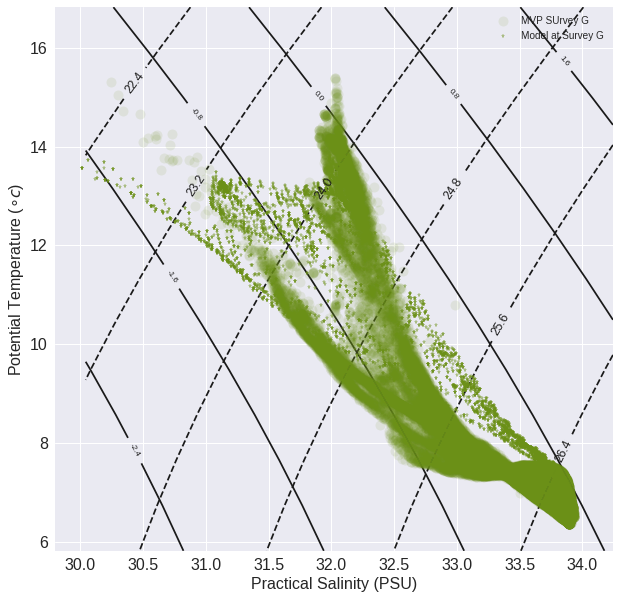

In [10]:
colors = cmo.cm.phase(np.linspace(0, 1, 203))

SA_loc_cs_D1 = SA_loc_cs_D[SA_loc_cs_D>30]
CT_loc_cs_D1 = CT_loc_cs_D[SA_loc_cs_D>30]

# Figure out boudaries (mins and maxs)
smin = SA_loc_cs_G.min() - (0.01 * SA_loc_cs_G.min())
smax = SA_loc_cs_G.max() + (0.01 * SA_loc_cs_G.max())
tmin = CT_loc_cs_G.min() - (0.1 * CT_loc_cs_G.max())
tmax = CT_loc_cs_G.max() + (0.1 * CT_loc_cs_G.max())
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, lon_gsw, lat_gsw)

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = plt.contour(si,ti,dens_1, linestyles='dashed', colors='k')
CS1 = plt.contour(si,ti,spic_1, linestyles='solid', colors='k')
plt.clabel(CS, fontsize=12, inline=1, fmt='%0.1f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.1f') # Label every second level


# ax.plot(SA_loc_cs_A ,CT_loc_cs_A,'o', color= colors[0,:], alpha = 0.5, markersize=3, label='MVP SUrvey A')

# ax.plot(SA_loc_cs_B ,CT_loc_cs_B, 'o',color= colors[30,:],alpha = 0.1,  markersize=10, label='MVP SUrvey B')

# ax.plot(SA_loc_cs_D1 ,CT_loc_cs_D1, 'o',color= colors[130,:],alpha = 0.1,  markersize=10, label='MVP SUrvey D')

# ax.plot(SA_loc_cs_E ,CT_loc_cs_E, 'o',color= colors[90,:], alpha = 0.5, markersize=3, label='MVP SUrvey E')

ax.plot(SA_loc_cs_G ,CT_loc_cs_G, 'o',color= colors[180,:], alpha = 0.1, markersize=10, label='MVP SUrvey G')



# ax.plot(model_survey_sal_B ,model_survey_temp_B, '*',color= colors[30,:],alpha = 0.5,  markersize=5, label='Model at Survey B')

# ax.plot(model_survey_sal_D ,model_survey_temp_D, '*',color= colors[130,:],alpha = 0.5,  markersize=5, label='Model at Survey D')

# ax.plot(model_survey_sal_E ,model_survey_temp_E, 'o',color= colors[90,:], alpha = 0.5, markersize=3, label='Model at Survey E')

ax.plot(model_survey_sal_G1 ,model_survey_temp_G1, '*',color= colors[180,:], alpha = 0.5, markersize=5, label='Model at Survey G')

# ax.plot(SA_loc_f, CT_loc_f, 'o' ,markersize=9, label = 'Eddy west front')
# ax.set_ylim(5,18)
# ax.set_xlim(30,34)
 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
# ax.set_xlim(31.5,)


legend = ax.legend(loc='upper right', fancybox=True, framealpha=1)

In [139]:
file = survey_file_B

In [140]:
mat = scipy.io.loadmat(file)

depths_survey = mat['depths'][:,0]
lat_survey = mat['latitude'][:,0]
lon_survey = mat['longitude'][:,0] - 100
# den_survey = mat['density'][:]
pden_survey = mat['pden'][:]
temp_survey = mat['temp'][:]
sal_survey = mat['salinity'][:]
mtime = mat['mtime'][:,0]

In [141]:
depths_survey.shape

(251,)

In [142]:
temp_survey.shape

(251, 168)

In [143]:
y = np.empty_like(temp_survey)

max_depths = np.empty((temp_survey.shape[1]))

y[:,:] = np.isnan(temp_survey)

for i in np.arange(max_depths.shape[0]):
    if (np.isfinite(temp_survey[:,i])).any() == True:
        max_depths[i] = np.max(depths_survey[np.isfinite(temp_survey[:,i])])

In [144]:
lon_max_depth = lon_survey[np.where(max_depths == np.max(max_depths))]
lat_max_depth = lat_survey[np.where(max_depths == np.max(max_depths))]
p_den_max_depth = pden_survey[:,np.where(max_depths == np.max(max_depths))]
p_den_max_depth = p_den_max_depth[:,0,:]
temp_den_max_depth = temp_survey[:,np.where(max_depths == np.max(max_depths))]
temp_den_max_depth = temp_den_max_depth[:,0,:]
sal_den_max_depth = sal_survey[:,np.where(max_depths == np.max(max_depths))]
sal_den_max_depth = sal_den_max_depth[:,0,:]



q = np.empty_like(lon_max_depth)
p = np.empty_like(q)

In [145]:
for i in np.arange(lat_max_depth.shape[0]):
    q[i], p[i] = geo_tools.find_closest_model_point(
               lon_max_depth[i],lat_max_depth[i],lon,lat,tols={
        'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

In [146]:
bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mbathy = mask.variables['mbathy'][0,180:350, 480:650]
Z = bathy.variables['Bathymetry'][180:350, 480:650]

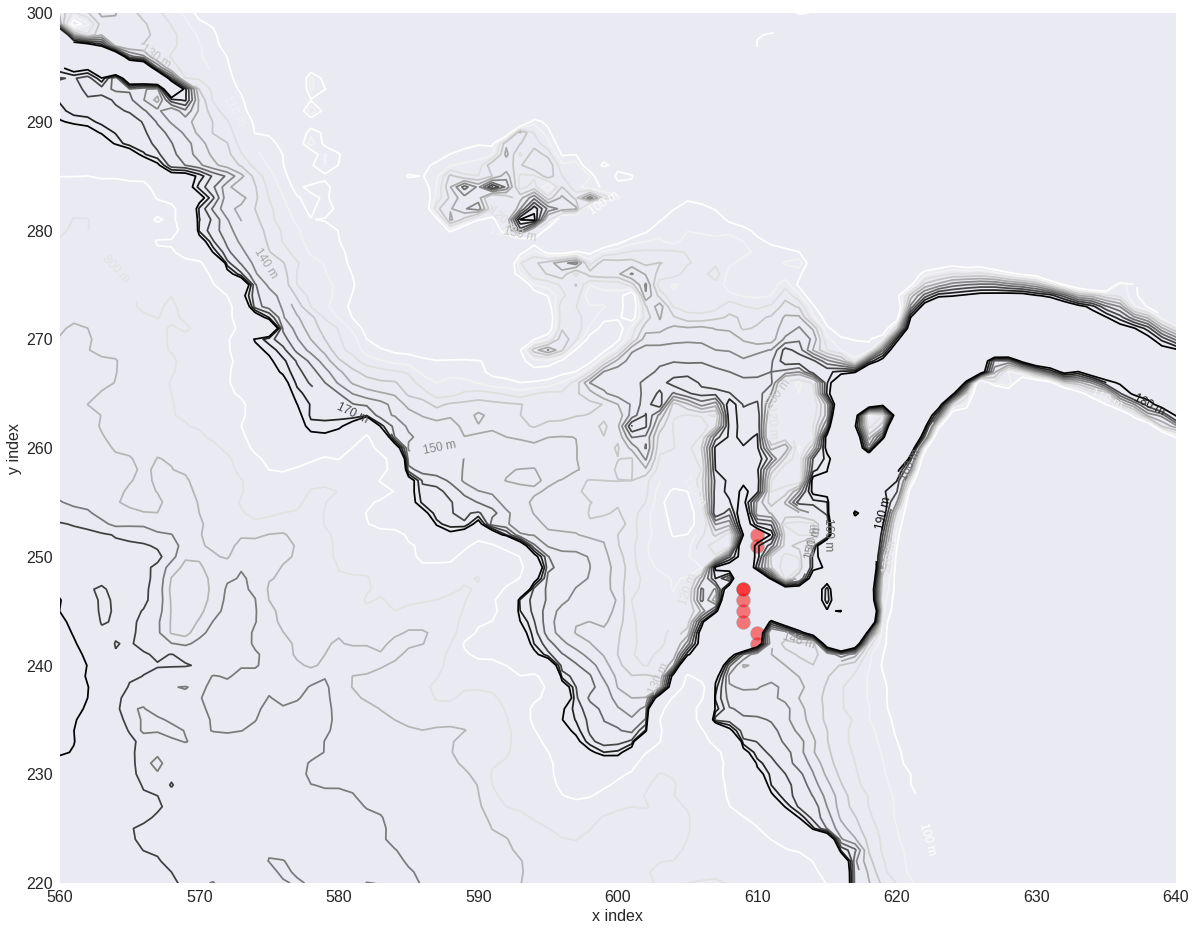

In [147]:
colors = cmo.cm.phase(np.linspace(0, 1, p.shape[0]))
# # plt.style.use('default')

# sns.set_context('paper')
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
# plt.style.use('seaborn')

cmap = cmo.cm.deep
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')

fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], level = [0,500,1000], color = 'k' )
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




for i in np.arange(p.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(p[i])], y_wcvi_slice[np.int(q[i])], c = 'Red', cmap = cmap, s=200, alpha=0.5, edgecolor= 'cyan' )


ax.set_ylim(220,300)
ax.set_xlim(560,640)
    
ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)


In [148]:
pressure = np.empty_like(sal_den_max_depth)
SA = np.empty_like(pressure)
CT = np.empty_like(SA)
spic_max_depth = np.empty_like(SA)
N_MVP = np.empty_like(SA)
pmid = np.empty_like(N_MVP)
Z_N_MVP = np.empty((pmid.shape[0]-1))


for j in np.arange(depths_survey.shape[0]):

    for i in np.arange(p.shape[0]):

        pressure[j,i] = gsw.p_from_z(-depths_survey[j],lat_max_depth[i])

        SA[j,i] = gsw.SA_from_SP(sal_den_max_depth[j,i], pressure[j,i], lon_max_depth[i], lat_max_depth[i])

        CT[j,i] = gsw.CT_from_pt(sal_den_max_depth[j,i], temp_den_max_depth[j,i])

        spic_max_depth[j,i] = gsw.spiciness0(SA[j,i], CT[j,i])
        
        
for i in np.arange(p.shape[0]): 
    N_MVP[1:,i],pmid[1:,i] = gsw.stability.Nsquared(SA[:,i], CT[:,i], pressure[:,i], lat_max_depth[0])
    
Z_N_MVP[:] = -gsw.z_from_p(pmid[1:,0], lat_max_depth[0])

In [149]:
model_maxdepth_sal = np.empty((sal.shape[1],q.shape[0]))
model_maxdepth_temp = np.empty_like(model_maxdepth_sal)
model_maxdepth_rho = np.empty_like(model_maxdepth_sal)
model_maxdepth_spic = np.empty_like(model_maxdepth_sal)

t = 116



for i in np.arange(p.shape[0]):
    model_maxdepth_sal[:,i]   = sal[t,:,q[i],p[i]]
    model_maxdepth_temp[:,i]  = temp[t,:,q[i],p[i]]
    model_maxdepth_spic[:,i]  = spic[t,:,q[i],p[i]]
    model_maxdepth_rho[:,i]   = rho[t,:,q[i],p[i]]
    


pressure_model = np.empty_like(model_maxdepth_sal)
SA_model = np.empty_like(pressure_model)
CT_model = np.empty_like(SA_model)
N_model = np.empty_like(SA_model)
pmid_model = np.empty_like(N_model)
Z_N_model = np.empty((pmid_model.shape[0]-1))
    
for j in np.arange(model_maxdepth_sal.shape[0]):

    for i in np.arange(model_maxdepth_sal.shape[1]):

        pressure_model[j,i] = gsw.p_from_z(-zlevels[j],lat_max_depth[0])

        SA_model[j,i] = gsw.SA_from_SP(model_maxdepth_sal[j,i], pressure_model[j,i], lon_max_depth[i], lat_max_depth[i])

        CT_model[j,i] = gsw.CT_from_pt(model_maxdepth_sal[j,i], model_maxdepth_temp[j,i])
    

for i in np.arange(p.shape[0]): 
    N_model[1:,i],pmid_model[1:,i] = gsw.stability.Nsquared(SA_model[:,i], CT_model[:,i], pressure_model[:,i], lat_max_depth[0])
    
Z_N_model[:] = -gsw.z_from_p(pmid_model[1:,0], lat_max_depth[0])

In [150]:
model_maxdepth_sal.shape

(32, 9)

At shelf break depth inside the Tully Canyon


(-0.5, 0.1)

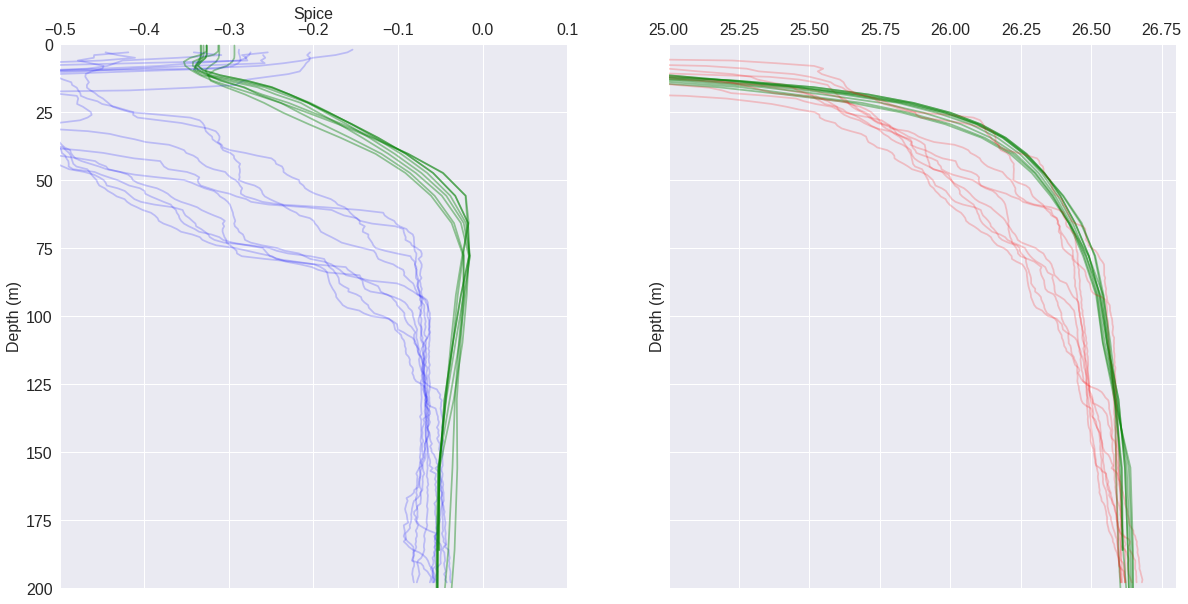

In [151]:
print("At shelf break depth inside the Tully Canyon")
model_maxdepth_spic[model_maxdepth_spic < -10] = np.nan
model_maxdepth_rho[model_maxdepth_rho - 1000 < 0] = np.nan

# fig2, (ax2, ax3, ax4) = plt.subplots(1,3,sharey=True,figsize=(15,8))

fig2, (ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(20,10))
# Temperature
for i in np.arange(p.shape[0]):
#     ax2.plot(model_survey_sal[:,i,i],zlevels[:], c = colors[i,:])
    ax2.plot(p_den_max_depth[:,i]-1000 ,depths_survey[:],  c = 'red', alpha = 0.2, label = 'MVP')
    ax2.plot(model_maxdepth_rho[:,i]-1000, zlevels[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,200)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
# ax2.set_xlabel('Density', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.set_xlim(25,26.8)


for i in np.arange(p.shape[0]):
#     ax2.plot(model_survey_sal[:,i,i],zlevels[:], c = colors[i,:])
    ax1.plot(spic_max_depth[:,i] ,depths_survey[:], c = 'blue', alpha = 0.2, label = 'MVP')
    ax1.plot(model_maxdepth_spic[:,i], zlevels[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax1.set_ylabel('Depth (m)', fontsize = 16)
ax1.set_ylim(0,200)
ax1.set_ylim(ax2.get_ylim()[::-1]) 
ax1.set_xlabel('Spice', fontsize = 16)
ax1.xaxis.set_label_position('top') 
ax1.xaxis.set_ticks_position('top') 
ax1.tick_params(axis='both',labelsize =16)
ax1.set_xlim(-0.5,0.1)


N at shelf break depth inside the Tully Canyon


/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()


(-0.0001, 0.0025)

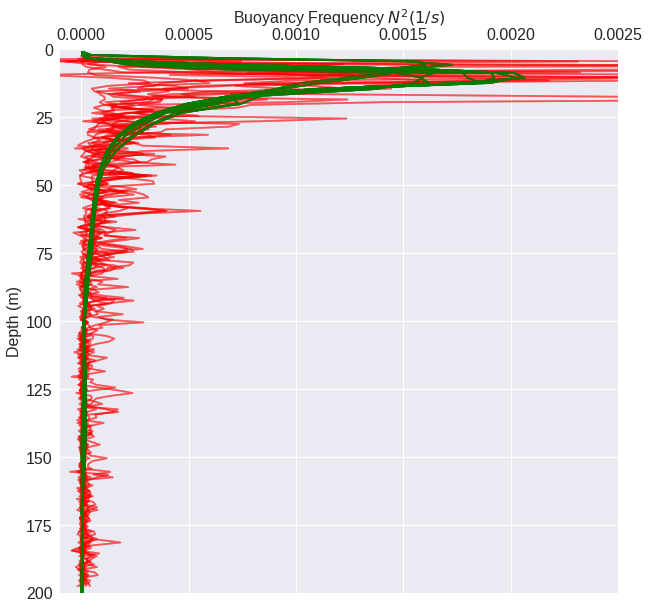

In [153]:
print("N at shelf break depth inside the Tully Canyon")

N_model[N_model < -0.005] = np.nan

fig2, ax2 = plt.subplots(1,1,figsize=(10,10))
# Temperature
for i in np.arange(p.shape[0]):
    ax2.plot(N_MVP[1:,:] ,Z_N_MVP[:],  c = 'red', alpha = 0.1, label = 'MVP')
    ax2.plot(N_model[1:,:] ,Z_N_model[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,200)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Buoyancy Frequency $N^2 (1/s)$', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.set_xlim(-0.0001,0.0025)

In [116]:
file = survey_file_A

In [117]:
mat = scipy.io.loadmat(file)

depths_survey = mat['depths'][:,0]
lat_survey = mat['latitude'][:,0]
lon_survey = mat['longitude'][:,0] - 100
# den_survey = mat['density'][:]
pden_survey = mat['pden'][:]
temp_survey = mat['temp'][:]
sal_survey = mat['salinity'][:]
mtime = mat['mtime'][:,0]

In [118]:
y = np.empty_like(temp_survey)

max_depths = np.empty((temp_survey.shape[1]))

y[:,:] = np.isnan(temp_survey)

for i in np.arange(max_depths.shape[0]):
    if (np.isfinite(temp_survey[:,i])).any() == True:
        max_depths[i] = np.max(depths_survey[np.isfinite(temp_survey[:,i])])

In [119]:
lon_max_depth = lon_survey[np.where(max_depths == np.max(max_depths))]
lat_max_depth = lat_survey[np.where(max_depths == np.max(max_depths))]
p_den_max_depth = pden_survey[:,np.where(max_depths == np.max(max_depths))]
p_den_max_depth = p_den_max_depth[:,0,:]
temp_den_max_depth = temp_survey[:,np.where(max_depths == np.max(max_depths))]
temp_den_max_depth = temp_den_max_depth[:,0,:]
sal_den_max_depth = sal_survey[:,np.where(max_depths == np.max(max_depths))]
sal_den_max_depth = sal_den_max_depth[:,0,:]



q = np.empty_like(lon_max_depth)
p = np.empty_like(q)

In [120]:
for i in np.arange(lat_max_depth.shape[0]):
    q[i], p[i] = geo_tools.find_closest_model_point(
               lon_max_depth[i],lat_max_depth[i],lon,lat,tols={
        'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

In [121]:
bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mbathy = mask.variables['mbathy'][0,180:350, 480:650]
Z = bathy.variables['Bathymetry'][180:350, 480:650]

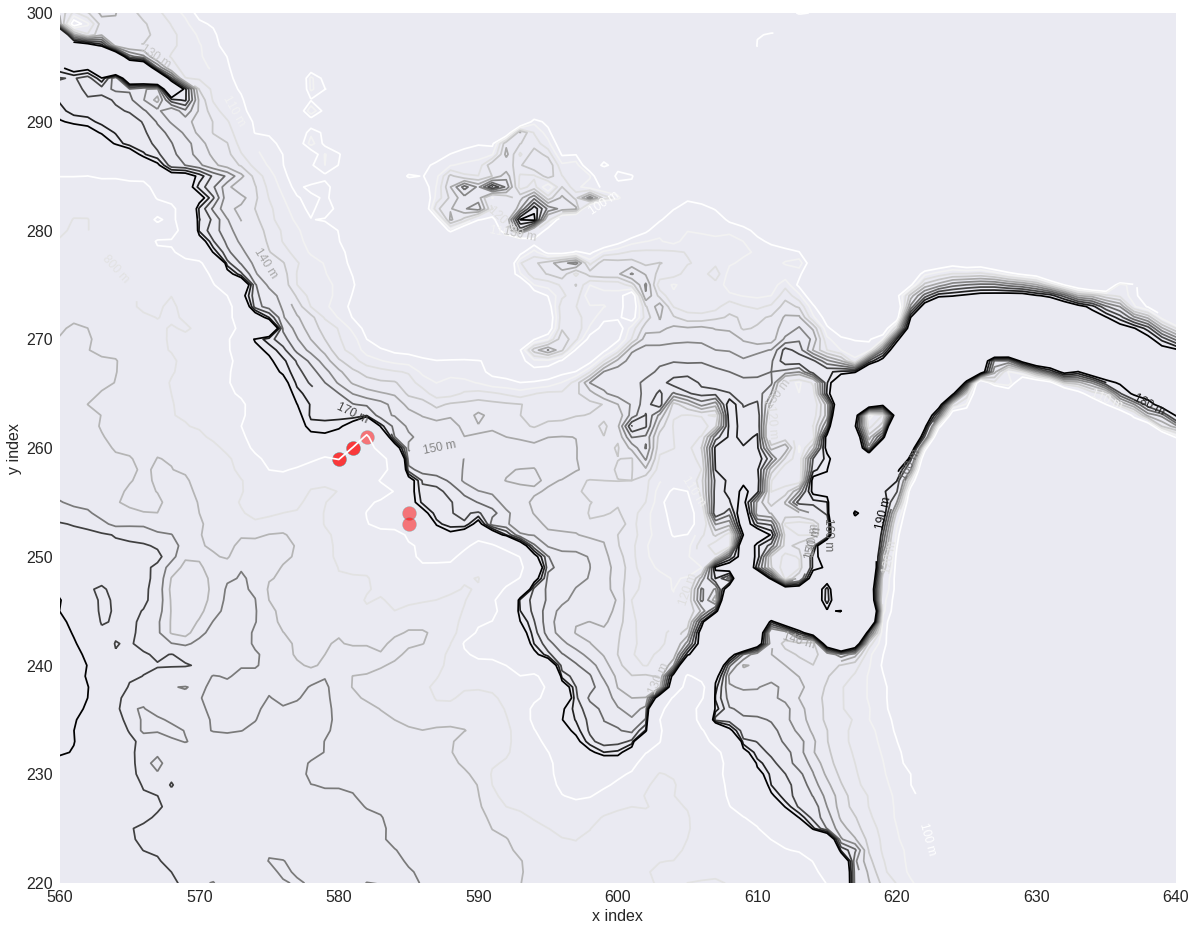

In [122]:
colors = cmo.cm.phase(np.linspace(0, 1, p.shape[0]))
# # plt.style.use('default')

# sns.set_context('paper')
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
# plt.style.use('seaborn')

cmap = cmo.cm.deep
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')

fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], level = [0,500,1000], color = 'k' )
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




for i in np.arange(p.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(p[i])], y_wcvi_slice[np.int(q[i])], c = 'Red', cmap = cmap, s=200, alpha=0.5, edgecolor= 'cyan' )


ax.set_ylim(220,300)
ax.set_xlim(560,640)
    
ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)


In [123]:
pressure = np.empty_like(sal_den_max_depth)
SA = np.empty_like(pressure)
CT = np.empty_like(SA)
spic_max_depth = np.empty_like(SA)
N_MVP = np.empty_like(SA)
pmid = np.empty_like(N_MVP)
Z_N_MVP = np.empty((pmid.shape[0]-1))


for j in np.arange(depths_survey.shape[0]):

    for i in np.arange(p.shape[0]):

        pressure[j,i] = gsw.p_from_z(-depths_survey[j],lat_max_depth[i])

        SA[j,i] = gsw.SA_from_SP(sal_den_max_depth[j,i], pressure[j,i], lon_max_depth[i], lat_max_depth[i])

        CT[j,i] = gsw.CT_from_pt(sal_den_max_depth[j,i], temp_den_max_depth[j,i])

        spic_max_depth[j,i] = gsw.spiciness0(SA[j,i], CT[j,i])
        
        
for i in np.arange(p.shape[0]): 
    N_MVP[1:,i],pmid[1:,i] = gsw.stability.Nsquared(SA[:,i], CT[:,i], pressure[:,i], lat_max_depth[0])
    
Z_N_MVP[:] = -gsw.z_from_p(pmid[1:,0], lat_max_depth[0])

model_maxdepth_sal = np.empty((sal.shape[1],q.shape[0]))
model_maxdepth_temp = np.empty_like(model_maxdepth_sal)
model_maxdepth_rho = np.empty_like(model_maxdepth_sal)
model_maxdepth_spic = np.empty_like(model_maxdepth_sal)

t = 116



for i in np.arange(p.shape[0]):
    model_maxdepth_sal[:,i]   = sal[t,:,q[i],p[i]]
    model_maxdepth_temp[:,i]  = temp[t,:,q[i],p[i]]
    model_maxdepth_spic[:,i]  = spic[t,:,q[i],p[i]]
    model_maxdepth_rho[:,i]   = rho[t,:,q[i],p[i]]
    


pressure_model = np.empty_like(model_maxdepth_sal)
SA_model = np.empty_like(pressure_model)
CT_model = np.empty_like(SA_model)
N_model = np.empty_like(SA_model)
pmid_model = np.empty_like(N_model)
Z_N_model = np.empty((pmid_model.shape[0]-1))
    
for j in np.arange(model_maxdepth_sal.shape[0]):

    for i in np.arange(model_maxdepth_sal.shape[1]):

        pressure_model[j,i] = gsw.p_from_z(-zlevels[j],lat_max_depth[0])

        SA_model[j,i] = gsw.SA_from_SP(model_maxdepth_sal[j,i], pressure_model[j,i], lon_max_depth[i], lat_max_depth[i])

        CT_model[j,i] = gsw.CT_from_pt(model_maxdepth_sal[j,i], model_maxdepth_temp[j,i])
    

for i in np.arange(p.shape[0]): 
    N_model[1:,i],pmid_model[1:,i] = gsw.stability.Nsquared(SA_model[:,i], CT_model[:,i], pressure_model[:,i], lat_max_depth[0])
    
Z_N_model[:] = -gsw.z_from_p(pmid_model[1:,0], lat_max_depth[0])

At shelf break depth upstream and downstream of Barkley Canyon


(-0.5, 0.1)

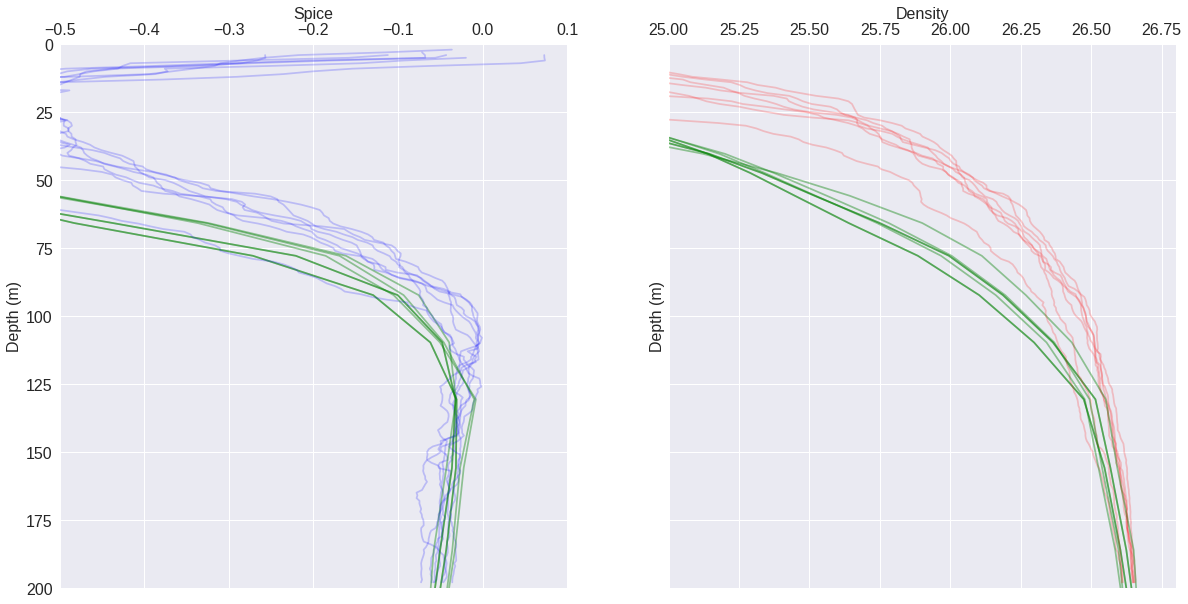

In [124]:
print("At shelf break depth upstream and downstream of Barkley Canyon")

model_maxdepth_spic[model_maxdepth_spic < -10] = np.nan
model_maxdepth_rho[model_maxdepth_rho - 1000 < 0] = np.nan

# fig2, (ax2, ax3, ax4) = plt.subplots(1,3,sharey=True,figsize=(15,8))

fig2, (ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(20,10))
# Temperature
for i in np.arange(p.shape[0]):
#     ax2.plot(model_survey_sal[:,i,i],zlevels[:], c = colors[i,:])
    ax2.plot(p_den_max_depth[:,i]-1000 ,depths_survey[:],  c = 'red', alpha = 0.2, label = 'MVP')
    ax2.plot(model_maxdepth_rho[:,i]-1000, zlevels[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,200)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Density', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.set_xlim(25,26.8)


for i in np.arange(p.shape[0]):
#     ax2.plot(model_survey_sal[:,i,i],zlevels[:], c = colors[i,:])
    ax1.plot(spic_max_depth[:,i] ,depths_survey[:], c = 'blue', alpha = 0.2, label = 'MVP')
    ax1.plot(model_maxdepth_spic[:,i], zlevels[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax1.set_ylabel('Depth (m)', fontsize = 16)
ax1.set_ylim(0,200)
ax1.set_ylim(ax2.get_ylim()[::-1]) 
ax1.set_xlabel('Spice', fontsize = 16)
ax1.xaxis.set_label_position('top') 
ax1.xaxis.set_ticks_position('top') 
ax1.tick_params(axis='both',labelsize =16)
ax1.set_xlim(-0.5,0.1)


At shelf break depth upstream and downstream of Barkley Canyon
The model predicts a much more stratified scenario as compared to the real world


(-0.0001, 0.0025)

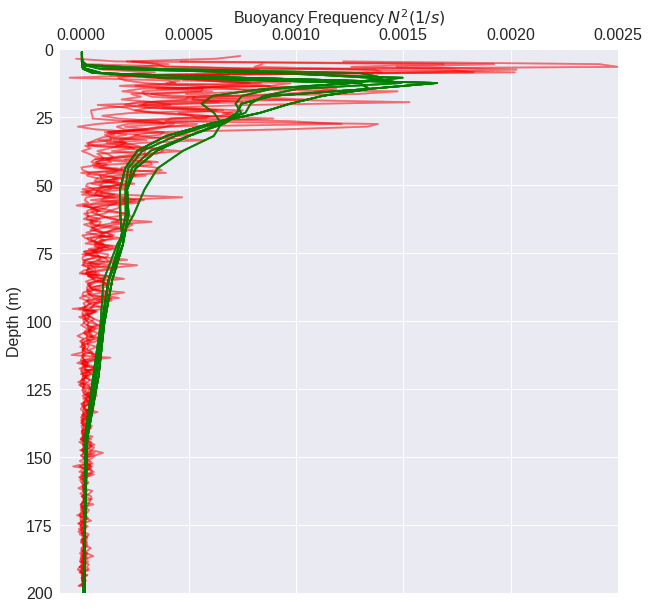

In [129]:
print("At shelf break depth upstream and downstream of Barkley Canyon")

print("The model predicts a much more stratified scenario as compared to the real world")


fig2, ax2 = plt.subplots(1,1,figsize=(10,10))
# Temperature
for i in np.arange(p.shape[0]):
    ax2.plot(N_MVP[1:,:] ,Z_N_MVP[:],  c = 'red', alpha = 0.1, label = 'MVP')
    ax2.plot(N_model[1:,:] ,Z_N_model[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,200)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Buoyancy Frequency $N^2 (1/s)$', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.set_xlim(-0.0001,0.0025)

In [130]:
lon_max_depth = lon_survey[np.where((max_depths < np.mean(max_depths)) & (max_depths > 118))]
lat_max_depth = lat_survey[np.where((max_depths < np.mean(max_depths)) & (max_depths > 118))]
p_den_max_depth = pden_survey[:,np.where((max_depths < np.mean(max_depths)) & (max_depths > 118))]
p_den_max_depth = p_den_max_depth[:,0,:]
temp_den_max_depth = temp_survey[:,np.where((max_depths < np.mean(max_depths)) & (max_depths > 118))]
temp_den_max_depth = temp_den_max_depth[:,0,:]
sal_den_max_depth = sal_survey[:,np.where((max_depths < np.mean(max_depths)) & (max_depths > 118))]
sal_den_max_depth = sal_den_max_depth[:,0,:]



q = np.empty_like(lon_max_depth)
p = np.empty_like(q)

In [131]:
for i in np.arange(lat_max_depth.shape[0]):
    q[i], p[i] = geo_tools.find_closest_model_point(
               lon_max_depth[i],lat_max_depth[i],lon,lat,tols={
        'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

In [132]:
bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mbathy = mask.variables['mbathy'][0,180:350, 480:650]
Z = bathy.variables['Bathymetry'][180:350, 480:650]

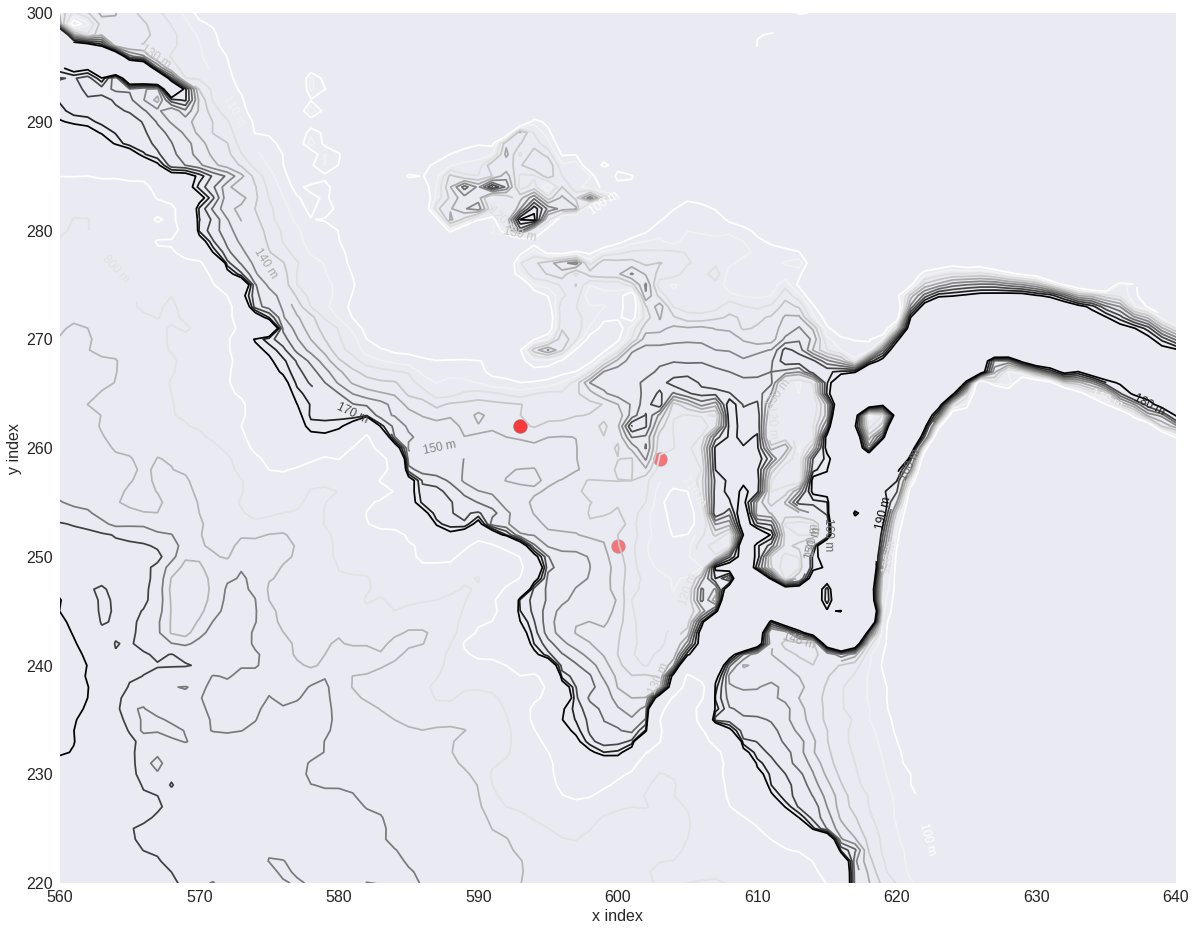

In [133]:
colors = cmo.cm.phase(np.linspace(0, 1, p.shape[0]))
# # plt.style.use('default')

# sns.set_context('paper')
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
# plt.style.use('seaborn')

cmap = cmo.cm.deep
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')

fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], level = [0,500,1000], color = 'k' )
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




for i in np.arange(p.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(p[i])], y_wcvi_slice[np.int(q[i])], c = 'Red', cmap = cmap, s=200, alpha=0.5, edgecolor= 'cyan' )


ax.set_ylim(220,300)
ax.set_xlim(560,640)
    
ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)


In [134]:
pressure = np.empty_like(sal_den_max_depth)
SA = np.empty_like(pressure)
CT = np.empty_like(SA)
spic_max_depth = np.empty_like(SA)
N_MVP = np.empty_like(SA)
pmid = np.empty_like(N_MVP)
Z_N_MVP = np.empty((pmid.shape[0]-1))


for j in np.arange(depths_survey.shape[0]):

    for i in np.arange(p.shape[0]):

        pressure[j,i] = gsw.p_from_z(-depths_survey[j],lat_max_depth[i])

        SA[j,i] = gsw.SA_from_SP(sal_den_max_depth[j,i], pressure[j,i], lon_max_depth[i], lat_max_depth[i])

        CT[j,i] = gsw.CT_from_pt(sal_den_max_depth[j,i], temp_den_max_depth[j,i])

        spic_max_depth[j,i] = gsw.spiciness0(SA[j,i], CT[j,i])
        
        
for i in np.arange(p.shape[0]): 
    N_MVP[1:,i],pmid[1:,i] = gsw.stability.Nsquared(SA[:,i], CT[:,i], pressure[:,i], lat_max_depth[0])
    
Z_N_MVP[:] = -gsw.z_from_p(pmid[1:,0], lat_max_depth[0])

model_maxdepth_sal = np.empty((sal.shape[1],q.shape[0]))
model_maxdepth_temp = np.empty_like(model_maxdepth_sal)
model_maxdepth_rho = np.empty_like(model_maxdepth_sal)
model_maxdepth_spic = np.empty_like(model_maxdepth_sal)

t = 116



for i in np.arange(p.shape[0]):
    model_maxdepth_sal[:,i]   = sal[t,:,q[i],p[i]]
    model_maxdepth_temp[:,i]  = temp[t,:,q[i],p[i]]
    model_maxdepth_spic[:,i]  = spic[t,:,q[i],p[i]]
    model_maxdepth_rho[:,i]   = rho[t,:,q[i],p[i]]
    


pressure_model = np.empty_like(model_maxdepth_sal)
SA_model = np.empty_like(pressure_model)
CT_model = np.empty_like(SA_model)
N_model = np.empty_like(SA_model)
pmid_model = np.empty_like(N_model)
Z_N_model = np.empty((pmid_model.shape[0]-1))
    
for j in np.arange(model_maxdepth_sal.shape[0]):

    for i in np.arange(model_maxdepth_sal.shape[1]):

        pressure_model[j,i] = gsw.p_from_z(-zlevels[j],lat_max_depth[0])

        SA_model[j,i] = gsw.SA_from_SP(model_maxdepth_sal[j,i], pressure_model[j,i], lon_max_depth[i], lat_max_depth[i])

        CT_model[j,i] = gsw.CT_from_pt(model_maxdepth_sal[j,i], model_maxdepth_temp[j,i])
    

for i in np.arange(p.shape[0]): 
    N_model[1:,i],pmid_model[1:,i] = gsw.stability.Nsquared(SA_model[:,i], CT_model[:,i], pressure_model[:,i], lat_max_depth[0])
    
Z_N_model[:] = -gsw.z_from_p(pmid_model[1:,0], lat_max_depth[0])

Onshore shelf region


/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in less


(-0.7, 0.1)

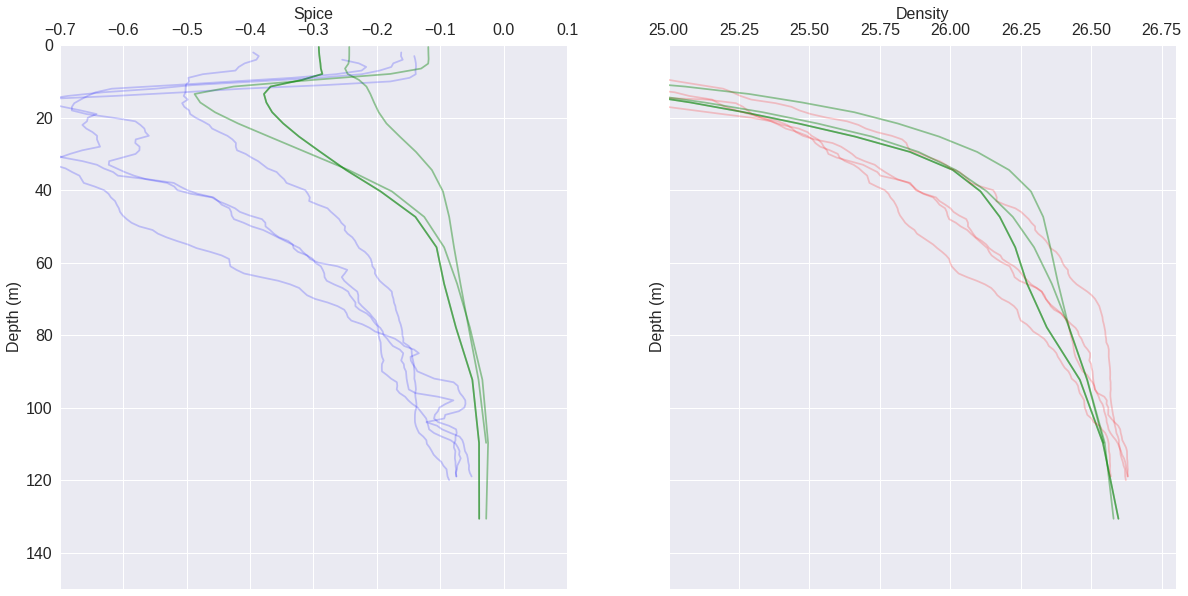

In [136]:
print("Onshore shelf region")

model_maxdepth_spic[model_maxdepth_spic < -10] = np.nan
model_maxdepth_rho[model_maxdepth_rho - 1000 < 0] = np.nan
# fig2, (ax2, ax3, ax4) = plt.subplots(1,3,sharey=True,figsize=(15,8))

fig2, (ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(20,10))
# Temperature
for i in np.arange(p.shape[0]):
#     ax2.plot(model_survey_sal[:,i,i],zlevels[:], c = colors[i,:])
    ax2.plot(p_den_max_depth[:,i]-1000 ,depths_survey[:],  c = 'red', alpha = 0.2, label = 'MVP')
    ax2.plot(model_maxdepth_rho[:,i]-1000, zlevels[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,150)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Density', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.set_xlim(25,26.8)


for i in np.arange(p.shape[0]):
#     ax2.plot(model_survey_sal[:,i,i],zlevels[:], c = colors[i,:])
    ax1.plot(spic_max_depth[:,i] ,depths_survey[:], c = 'blue', alpha = 0.2, label = 'MVP')
    ax1.plot(model_maxdepth_spic[:,i], zlevels[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax1.set_ylabel('Depth (m)', fontsize = 16)
ax1.set_ylim(0,150)
ax1.set_ylim(ax2.get_ylim()[::-1]) 
ax1.set_xlabel('Spice', fontsize = 16)
ax1.xaxis.set_label_position('top') 
ax1.xaxis.set_ticks_position('top') 
ax1.tick_params(axis='both',labelsize =16)
ax1.set_xlim(-0.7,0.1)


At shelf break depth upstream and downstream of Barkley Canyon
The model predicts a much more stratified scenario as compared to the real world


/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in less


(-0.0001, 0.0025)

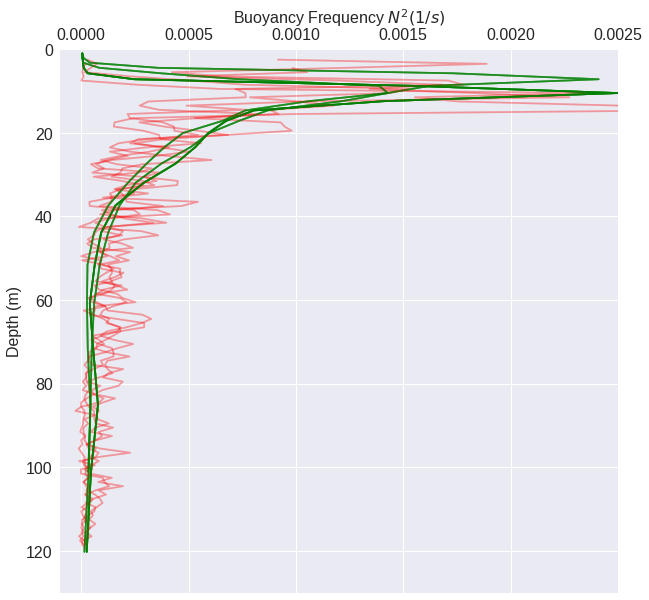

In [138]:
print("At shelf break depth upstream and downstream of Barkley Canyon")

print("The model predicts a much more stratified scenario as compared to the real world")

N_model[N_model < -0.005]  = np.nan

fig2, ax2 = plt.subplots(1,1,figsize=(10,10))
# Temperature
for i in np.arange(p.shape[0]):
    ax2.plot(N_MVP[1:,:] ,Z_N_MVP[:],  c = 'red', alpha = 0.1, label = 'MVP')
    ax2.plot(N_model[1:,:] ,Z_N_model[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,130)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Buoyancy Frequency $N^2 (1/s)$', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.set_xlim(-0.0001,0.0025)

In [233]:
file = survey_file_E

In [234]:
mat = scipy.io.loadmat(file)

depths_survey = mat['depths'][:,0]
lat_survey = mat['latitude'][:,0]
lon_survey = mat['longitude'][:,0] - 100
# den_survey = mat['density'][:]
pden_survey = mat['pden'][:]
temp_survey = mat['temp'][:]
sal_survey = mat['salinity'][:]
mtime = mat['mtime'][:,0]

In [235]:
y = np.empty_like(temp_survey)

max_depths = np.empty((temp_survey.shape[1]))

y[:,:] = np.isnan(temp_survey)

for i in np.arange(max_depths.shape[0]):
    if (np.isfinite(temp_survey[:,i])).any() == True:
        max_depths[i] = np.max(depths_survey[np.isfinite(temp_survey[:,i])])

In [236]:
lon_max_depth = lon_survey[np.where(max_depths == np.max(max_depths))]
lat_max_depth = lat_survey[np.where(max_depths == np.max(max_depths))]
p_den_max_depth = pden_survey[:,np.where(max_depths == np.max(max_depths))]
p_den_max_depth = p_den_max_depth[:,0,:]
temp_den_max_depth = temp_survey[:,np.where(max_depths == np.max(max_depths))]
temp_den_max_depth = temp_den_max_depth[:,0,:]
sal_den_max_depth = sal_survey[:,np.where(max_depths == np.max(max_depths))]
sal_den_max_depth = sal_den_max_depth[:,0,:]



q = np.empty_like(lon_max_depth)
p = np.empty_like(q)

In [237]:
for i in np.arange(lat_max_depth.shape[0]):
    q[i], p[i] = geo_tools.find_closest_model_point(
               lon_max_depth[i],lat_max_depth[i],lon,lat,tols={
        'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

In [238]:
bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

mbathy = mask.variables['mbathy'][0,180:350, 480:650]
Z = bathy.variables['Bathymetry'][180:350, 480:650]

In [239]:
p

array([ 128.,  128.,  127.,  115.,  115.,  114.,  113.,   89.,   99.,
         97.,   95.,   95.,   94.,   93.,   91.,   91.,   91.,   91.,
         91.,   92.,   92.,   93.,   94.,   94.,   96.,   96.,   98.,
         99.,  101.,  101.,  102.,  104.,  104.,  105.,  104.,  103.,
        103.,  102.,  101.,  100.,  100.,   99.,   98.,   95.,   93.,   92.])

In [240]:
p1 = p[q>70]
q1 = q[p<100]
q = q1[q1>70]
p = p1[p1<100]

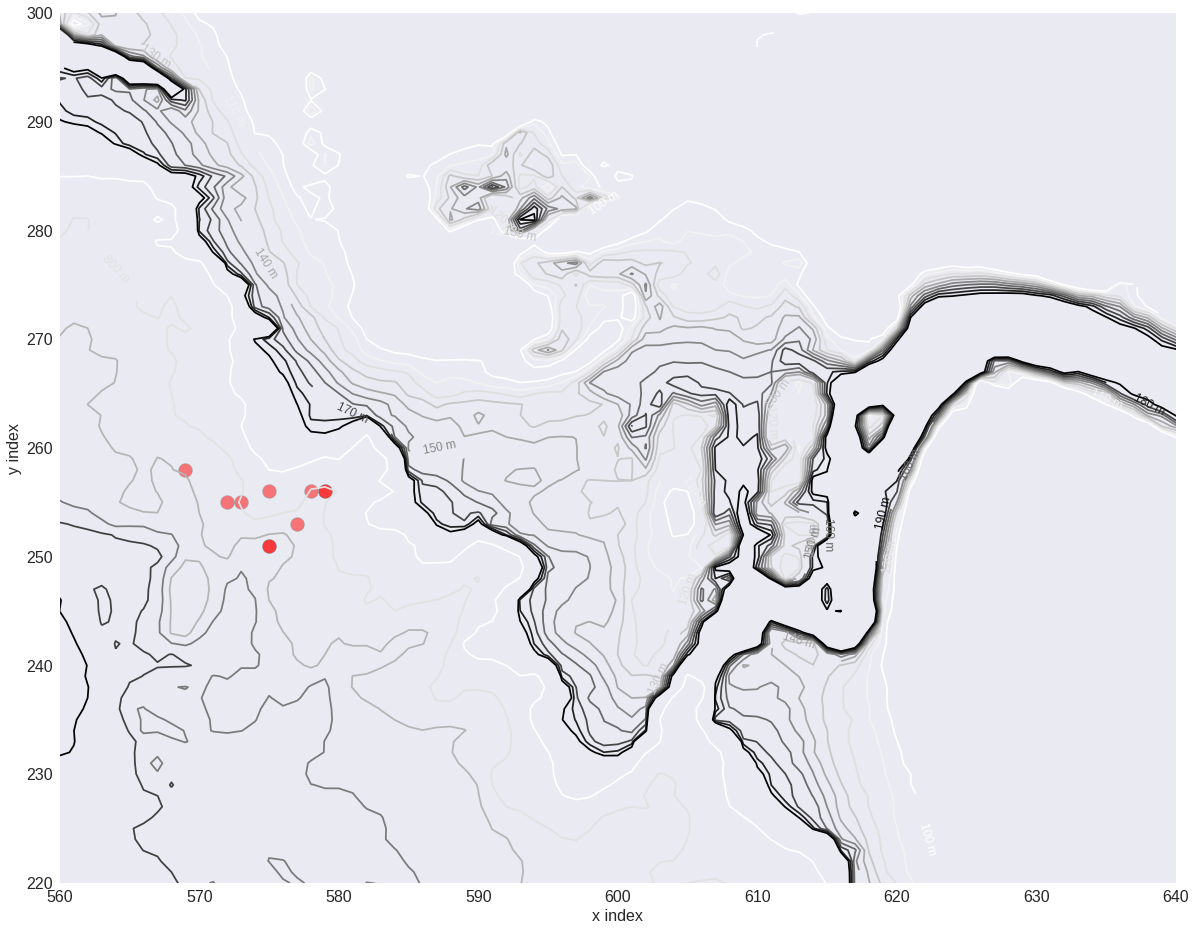

In [241]:
colors = cmo.cm.phase(np.linspace(0, 1, p.shape[0]))
# # plt.style.use('default')

# sns.set_context('paper')
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
# plt.style.use('seaborn')

cmap = cmo.cm.deep
#     cmap.set_bad('burlywood')
cmap.set_bad('#8b7765')

fig, ax = plt.subplots(1, 1, figsize=(20,16)); ax.grid()
#     ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=np.mean(lon)))
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], np.arange(100,200,10))
CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[:,:], level = [0,500,1000], color = 'k' )
CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




for i in np.arange(p.shape[0]):

    ax.scatter(x_wcvi_slice[np.int(p[i])], y_wcvi_slice[np.int(q[i])], c = 'Red', cmap = cmap, s=200, alpha=0.5, edgecolor= 'cyan' )


ax.set_ylim(220,300)
ax.set_xlim(560,640)
    
ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)


In [242]:
pressure = np.empty_like(sal_den_max_depth)
SA = np.empty_like(pressure)
CT = np.empty_like(SA)
spic_max_depth = np.empty_like(SA)
N_MVP = np.empty_like(SA)
pmid = np.empty_like(N_MVP)
Z_N_MVP = np.empty((pmid.shape[0]-1))


for j in np.arange(depths_survey.shape[0]):

    for i in np.arange(p.shape[0]):

        pressure[j,i] = gsw.p_from_z(-depths_survey[j],lat_max_depth[i])

        SA[j,i] = gsw.SA_from_SP(sal_den_max_depth[j,i], pressure[j,i], lon_max_depth[i], lat_max_depth[i])

        CT[j,i] = gsw.CT_from_pt(sal_den_max_depth[j,i], temp_den_max_depth[j,i])

        spic_max_depth[j,i] = gsw.spiciness0(SA[j,i], CT[j,i])
        
        
for i in np.arange(p.shape[0]): 
    N_MVP[1:,i],pmid[1:,i] = gsw.stability.Nsquared(SA[:,i], CT[:,i], pressure[:,i], lat_max_depth[0])
    
Z_N_MVP[:] = -gsw.z_from_p(pmid[1:,0], lat_max_depth[0])

model_maxdepth_sal = np.empty((sal.shape[1],q.shape[0]))
model_maxdepth_temp = np.empty_like(model_maxdepth_sal)
model_maxdepth_rho = np.empty_like(model_maxdepth_sal)
model_maxdepth_spic = np.empty_like(model_maxdepth_sal)

t = 116



for i in np.arange(p.shape[0]):
    model_maxdepth_sal[:,i]   = sal[t,:,q[i],p[i]]
    model_maxdepth_temp[:,i]  = temp[t,:,q[i],p[i]]
    model_maxdepth_spic[:,i]  = spic[t,:,q[i],p[i]]
    model_maxdepth_rho[:,i]   = rho[t,:,q[i],p[i]]
    


pressure_model = np.empty_like(model_maxdepth_sal)
SA_model = np.empty_like(pressure_model)
CT_model = np.empty_like(SA_model)
N_model = np.empty_like(SA_model)
pmid_model = np.empty_like(N_model)
Z_N_model = np.empty((pmid_model.shape[0]-1))
    
for j in np.arange(model_maxdepth_sal.shape[0]):

    for i in np.arange(model_maxdepth_sal.shape[1]):

        pressure_model[j,i] = gsw.p_from_z(-zlevels[j],lat_max_depth[0])

        SA_model[j,i] = gsw.SA_from_SP(model_maxdepth_sal[j,i], pressure_model[j,i], lon_max_depth[i], lat_max_depth[i])

        CT_model[j,i] = gsw.CT_from_pt(model_maxdepth_sal[j,i], model_maxdepth_temp[j,i])
    

for i in np.arange(p.shape[0]): 
    N_model[1:,i],pmid_model[1:,i] = gsw.stability.Nsquared(SA_model[:,i], CT_model[:,i], pressure_model[:,i], lat_max_depth[0])
    
Z_N_model[:] = -gsw.z_from_p(pmid_model[1:,0], lat_max_depth[0])

Onshore shelf region


(-0.7, 0.1)

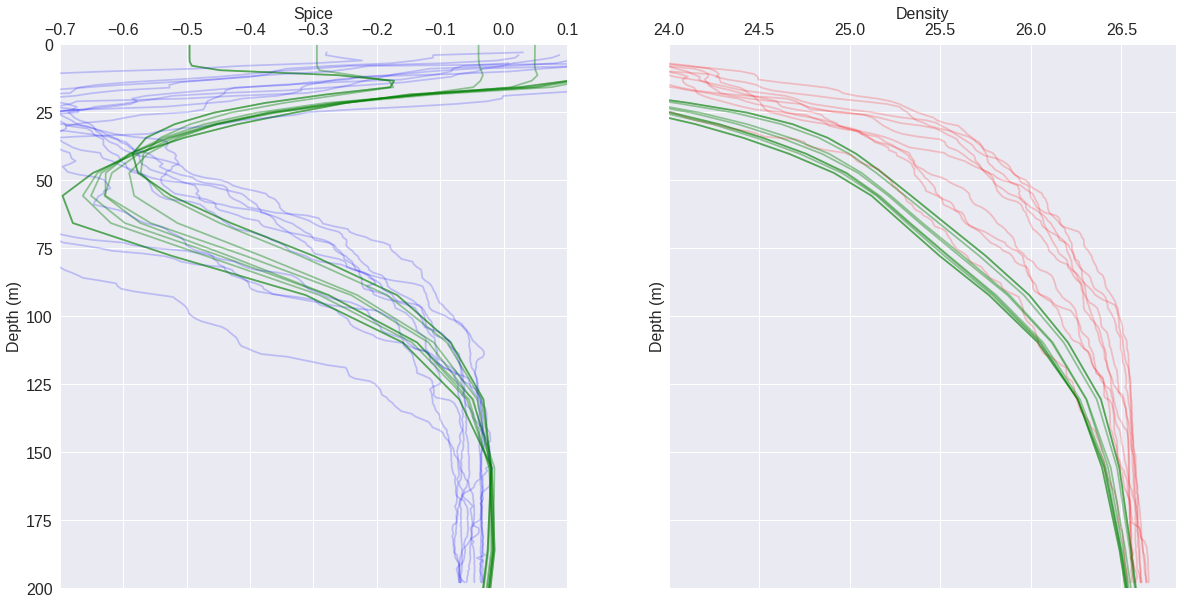

In [245]:
print("Onshore shelf region")

model_maxdepth_spic[model_maxdepth_spic < -10] = np.nan
model_maxdepth_rho[model_maxdepth_rho - 1000 < 0] = np.nan
# fig2, (ax2, ax3, ax4) = plt.subplots(1,3,sharey=True,figsize=(15,8))

fig2, (ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(20,10))
# Temperature
for i in np.arange(p.shape[0]):
#     ax2.plot(model_survey_sal[:,i,i],zlevels[:], c = colors[i,:])
    ax2.plot(p_den_max_depth[:,i]-1000 ,depths_survey[:],  c = 'red', alpha = 0.2, label = 'MVP')
    ax2.plot(model_maxdepth_rho[:,i]-1000, zlevels[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax2.set_ylabel('Depth (m)', fontsize = 16)
ax2.set_ylim(0,150)
ax2.set_ylim(ax2.get_ylim()[::-1]) 
ax2.set_xlabel('Density', fontsize = 16)
ax2.xaxis.set_label_position('top') 
ax2.xaxis.set_ticks_position('top') 
ax2.tick_params(axis='both',labelsize =16)
ax2.set_xlim(24,26.8)


for i in np.arange(p.shape[0]):
#     ax2.plot(model_survey_sal[:,i,i],zlevels[:], c = colors[i,:])
    ax1.plot(spic_max_depth[:,i] ,depths_survey[:], c = 'blue', alpha = 0.2, label = 'MVP')
    ax1.plot(model_maxdepth_spic[:,i], zlevels[:], c = 'green', alpha = 0.4, label = 'NEP36')
    
ax1.set_ylabel('Depth (m)', fontsize = 16)
ax1.set_ylim(0,200)
ax1.set_ylim(ax2.get_ylim()[::-1]) 
ax1.set_xlabel('Spice', fontsize = 16)
ax1.xaxis.set_label_position('top') 
ax1.xaxis.set_ticks_position('top') 
ax1.tick_params(axis='both',labelsize =16)
ax1.set_xlim(-0.7,0.1)


At shelf break depth upstream and downstream of Barkley Canyon
The model predicts a much more stratified scenario as compared to the real world


/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/transforms.py:2786: RuntimeWarning: overflow encountered in double_scalars
  elif vmax - vmin <= maxabsvalue * tiny:
/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_base.py:2322: RuntimeWarning: overflow encountered in double_scalars
  delta = (x1t - x0t) * margin


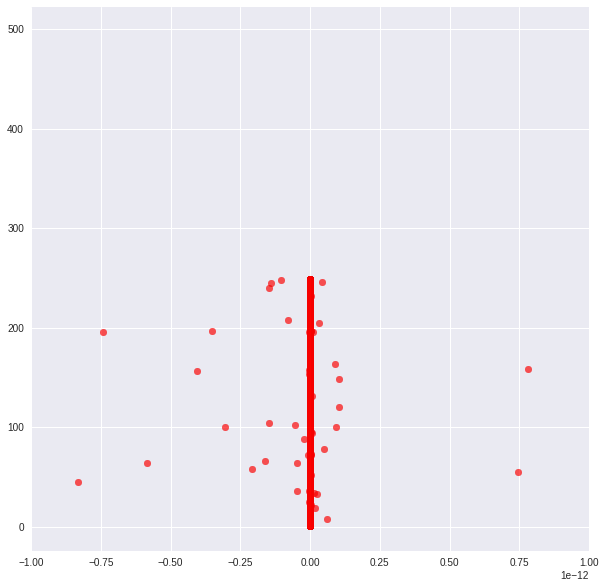

In [261]:
print("At shelf break depth upstream and downstream of Barkley Canyon")

print("The model predicts a much more stratified scenario as compared to the real world")

N_model[N_model < -0.005]  = np.nan

N_model = np.array(N_model, dtype=np.float64)
fig2, ax2 = plt.subplots(1,1,figsize=(10,10))
# Temperature
for i in np.arange(p.shape[0]):
    ax2.plot(N_MVP[1:,:] ,Z_N_MVP[:], 'o', c = 'red', alpha = 0.1, label = 'MVP')
    ax2.plot(N_model[1:,:] ,Z_N_model[:], 'o',c = 'green', alpha = 0.4, label = 'NEP36')
    
# ax2.set_ylabel('Depth (m)', fontsize = 16)
# ax2.set_ylim(0,200)
# ax2.set_ylim(ax2.get_ylim()[::-1]) 
# ax2.set_xlabel('Buoyancy Frequency $N^2 (1/s)$', fontsize = 16)
# ax2.xaxis.set_label_position('top') 
# ax2.xaxis.set_ticks_position('top') 
# ax2.tick_params(axis='both',labelsize =16)
# ax2.set_xlim(-0.0001,0.0025)

In [253]:
np.nanmax(N_model)

0.0012218168771047065

In [163]:
np.max(max_depths)

198.0

In [75]:
np.where(max_depths[max_depths> 150])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37]),)

In [90]:
model_maxdepth_rho[:,0] - 1000

array([ 22.75610352,  22.75640869,  22.7567749 ,  22.75720215,
        22.75842285,  22.76611328,  22.82476807,  23.01507568,
        23.28759766,  23.47955322,  23.60327148,  23.74053955,
        23.88739014,  24.0838623 ,  24.36352539,  24.72717285,
        25.13891602,  25.48852539,  25.80981445,  26.05517578,
        26.18640137,  26.2857666 ,  26.40405273,  -0.15551758,
        -0.15551758,  -0.15551758,  -0.15551758,  -0.15551758,
        -0.15551758,  -0.15551758,  -0.15551758,  -0.15551758])

In [174]:
depths_survey[np.isfinite(temp_survey[:,91])]

array([   8.,    9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,
         17.,   18.,   19.,   20.,   21.,   22.,   23.,   24.,   25.,
         26.,   27.,   28.,   29.,   30.,   31.,   32.,   33.,   34.,
         35.,   36.,   37.,   38.,   39.,   40.,   41.,   42.,   43.,
         44.,   45.,   46.,   47.,   48.,   49.,   50.,   51.,   52.,
         53.,   54.,   55.,   56.,   57.,   58.,   59.,   60.,   61.,
         62.,   63.,   64.,   65.,   66.,   67.,   68.,   69.,   70.,
         71.,   72.,   73.,   74.,   75.,   76.,   77.,   78.,   79.,
         80.,   81.,   82.,   83.,   84.,   85.,   86.,   87.,   88.,
         89.,   90.,   91.,   92.,   93.,   94.,   95.,   96.,   97.,
         98.,   99.,  100.,  101.,  102.,  103.,  104.,  105.,  106.,
        107.,  108.,  109.,  110.,  111.,  112.,  113.,  114.,  115.,
        116.,  117.,  118.,  119.,  120.,  121.,  122.,  123.,  124.,
        125.,  126.,  127.,  128.,  129.,  130.,  131.,  132.,  133.,
        134.,  135.,

In [46]:
temp_survey[0,:]

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  n

In [168]:
depths_survey[:]

array([   0.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,
          9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,
         18.,   19.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,
         27.,   28.,   29.,   30.,   31.,   32.,   33.,   34.,   35.,
         36.,   37.,   38.,   39.,   40.,   41.,   42.,   43.,   44.,
         45.,   46.,   47.,   48.,   49.,   50.,   51.,   52.,   53.,
         54.,   55.,   56.,   57.,   58.,   59.,   60.,   61.,   62.,
         63.,   64.,   65.,   66.,   67.,   68.,   69.,   70.,   71.,
         72.,   73.,   74.,   75.,   76.,   77.,   78.,   79.,   80.,
         81.,   82.,   83.,   84.,   85.,   86.,   87.,   88.,   89.,
         90.,   91.,   92.,   93.,   94.,   95.,   96.,   97.,   98.,
         99.,  100.,  101.,  102.,  103.,  104.,  105.,  106.,  107.,
        108.,  109.,  110.,  111.,  112.,  113.,  114.,  115.,  116.,
        117.,  118.,  119.,  120.,  121.,  122.,  123.,  124.,  125.,
        126.,  127.,